In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim
import torch

In [4]:
N_target=50

In [9]:
names=['fdm_asym_left','fdm_asym_right','fdm','GP','spectral']

train={}
for name in names+['u','f']:
    train[name]=np.stack([np.load(f'./data/{name}/{i}.npy') for i in range(1,501)],axis=0)
test={}
for name in names+['u','f']:
    test[name]=np.stack([np.load(f'./data/{name}/{i}.npy') for i in range(501,601)],axis=0)

# Make a Fourier Neural Operator

In [16]:


class FourierLayer(nn.Module):
    def __init__(self, in_features, out_features,frequency_number):
        super(FourierLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.frequency_number=frequency_number
        scale = (1 / (in_features * out_features))

        self.weight = nn.Parameter(scale * torch.rand(2*frequency_number,frequency_number,in_features,out_features, dtype=torch.cfloat))
        self.important_indexes=torch.cat([torch.arange(0,frequency_number),torch.arange(-frequency_number,0)])
        torch.nn.init.xavier_uniform_(self.weight)
    
    def __repr__(self):
        return self.__class__.__name__ + f' (in_features={self.in_features}, out_features={self.out_features},frequencies=({self.frequency_number},{self.frequency_number}))'
    
    def forward(self, x):
        fourier_transform = torch.fft.rfft2(x, dim=(1, 2))
        new_components = torch.zeros((*fourier_transform.shape[:-1],self.out_features),dtype=torch.cfloat)
        new_components[:,self.important_indexes,:self.frequency_number,:] = torch.einsum('xyij,bxyi->bxyj', self.weight, fourier_transform[:,self.important_indexes,:self.frequency_number,:])

        return torch.fft.irfft2(new_components, s=x.shape[1:3],dim=(1, 2))


class FNO(nn.Module):
    def __init__(self, in_features, out_features,hidden_dim,frequency_number):
        super(FNO, self).__init__()
        self.linear0 = nn.Linear(in_features, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.fourier1 = FourierLayer(hidden_dim, hidden_dim,frequency_number)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.fourier2 = FourierLayer(hidden_dim, hidden_dim,frequency_number)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.fourier3 = FourierLayer(hidden_dim, hidden_dim,frequency_number)
        self.linearfinal = nn.Linear(hidden_dim, out_features)
        self.relu = nn.ReLU()


    def forward(self, x,logits=False):
        x=self.linear0(x)
        x = self.linear1(x)+self.fourier1(x)
        x = self.relu(x)
        x = self.linear2(x)+self.fourier2(x)
        x = self.relu(x)
        x = self.linear3(x)+self.fourier3(x)
        x = self.relu(x)
        x = self.linearfinal(x)
        if logits:
            return x
        return torch.softmax(x,dim=-1)
fno=FNO(
    in_features = 6,
    out_features=5,
    hidden_dim=64,
    frequency_number=12
    )
fno

FNO(
  (linear0): Linear(in_features=6, out_features=64, bias=True)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (fourier1): FourierLayer (in_features=64, out_features=64,frequencies=(12,12))
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (fourier2): FourierLayer (in_features=64, out_features=64,frequencies=(12,12))
  (linear3): Linear(in_features=64, out_features=64, bias=True)
  (fourier3): FourierLayer (in_features=64, out_features=64,frequencies=(12,12))
  (linearfinal): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
)

# Load the data

In [12]:
#prepare the tensors as datasets
X_train=torch.tensor(train['f'],dtype=torch.float32)
model_values_train = torch.tensor(np.stack([train[model_name] for model_name in names],axis=1),dtype=torch.float32)
Y_train=torch.tensor(train['u'],dtype=torch.float32)
print(X_train.shape,model_values_train.shape,Y_train.shape)

train_dataset = TensorDataset(X_train,model_values_train, Y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)



torch.Size([500, 51, 51]) torch.Size([500, 5, 51, 51]) torch.Size([500, 51, 51])


# Train the FNO

training: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s, loss=159]


Epoch 1/20, Loss: 1.59e+02


training: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s, loss=73.9]


Epoch 2/20, Loss: 7.39e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, loss=59.9]


Epoch 3/20, Loss: 5.99e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s, loss=51.9]


Epoch 4/20, Loss: 5.19e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.61it/s, loss=43.4]


Epoch 5/20, Loss: 4.34e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s, loss=36]  


Epoch 6/20, Loss: 3.60e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s, loss=30.8]


Epoch 7/20, Loss: 3.08e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s, loss=20.9]


Epoch 8/20, Loss: 2.09e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, loss=16.3]


Epoch 9/20, Loss: 1.63e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s, loss=13.3]


Epoch 10/20, Loss: 1.33e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, loss=12.3]


Epoch 11/20, Loss: 1.23e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, loss=11.6]


Epoch 12/20, Loss: 1.16e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, loss=10.7]


Epoch 13/20, Loss: 1.07e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, loss=10.2]


Epoch 14/20, Loss: 1.02e+01


training: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, loss=9.52]


Epoch 15/20, Loss: 9.52e+00


training: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, loss=9.51]


Epoch 16/20, Loss: 9.51e+00


training: 100%|██████████| 16/16 [00:06<00:00,  2.59it/s, loss=9.08]


Epoch 17/20, Loss: 9.08e+00


training: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, loss=8.59]


Epoch 18/20, Loss: 8.59e+00


training: 100%|██████████| 16/16 [00:06<00:00,  2.58it/s, loss=8.35]


Epoch 19/20, Loss: 8.35e+00


training: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s, loss=8.06]

Epoch 20/20, Loss: 8.06e+00


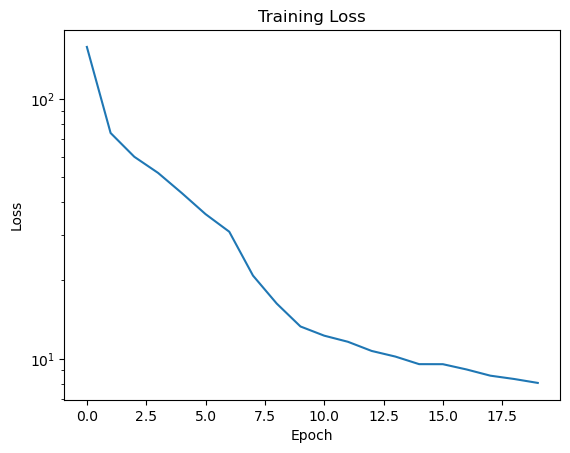

FNO(
  (linear0): Linear(in_features=6, out_features=64, bias=True)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (fourier1): FourierLayer (in_features=64, out_features=64,frequencies=(12,12))
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (fourier2): FourierLayer (in_features=64, out_features=64,frequencies=(12,12))
  (linear3): Linear(in_features=64, out_features=64, bias=True)
  (fourier3): FourierLayer (in_features=64, out_features=64,frequencies=(12,12))
  (linearfinal): Linear(in_features=64, out_features=5, bias=True)
  (relu): ReLU()
)

In [17]:


optimizer = optim.Adam(fno.parameters(), lr=0.005)
criterionMSE = nn.MSELoss()
def criterion_error(alphas,errors):
    return torch.mean(alphas**2*errors)
def criterion_log_error(alpha_logit,errors):
    return torch.mean((alpha_logit+torch.log(errors+1e-13))**2)

def train_epoch(model, train_loader, optimizer):
    model.train()
    running_loss = 0.0
    pbar=tqdm(train_loader, desc="training")
    i=1
    for data in pbar:
        X, model_values,Y = data
        inputs=torch.cat([X[:,None,:,:],model_values],dim=1).permute(0,2,3,1)
        errors=(Y[:,None,:,:]-model_values)**2
        optimizer.zero_grad()
        outputs = model(inputs,logits=True).permute(0,3,1,2)
        loss = criterion_log_error(outputs, errors)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'loss':running_loss/i})
        i+=1
    return running_loss / len(train_loader)

def eval_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(data_loader, 1):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(data_loader)

n_epochs = 20
train_losses = []
for epoch in range(n_epochs):
    train_loss = train_epoch(fno, train_loader, optimizer)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.2e}')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.show()

fno.eval()


In [18]:
alpha_train=fno(torch.cat([X_train[:,None,:,:],model_values_train],dim=1).permute(0,2,3,1)).permute(0,3,1,2)
pred_train = torch.sum(alpha_train*model_values_train,dim=1).detach().numpy()
Y_train=Y_train.numpy()

# Average error on the training set

In [19]:
np.mean(np.abs(pred_train-Y_train))

0.0007329098

# Testing

## Loading the data and predicting

In [25]:
input_test=torch.tensor(test['f'],dtype=torch.float32)
model_values_test = torch.tensor(np.stack([test[model_name] for model_name in names],axis=1),dtype=torch.float32)

alpha=fno(torch.cat([input_test[:,None,:,:],model_values_test],dim=1).permute(0,2,3,1)).permute(0,3,1,2)
pred = torch.sum(alpha*model_values_test,dim=1).detach().numpy()
alpha=alpha.detach().numpy()

In [30]:
model_to_test=model_values_test.detach().numpy()
Y_to_test=test['u']
errors_models= np.mean((model_to_test-Y_to_test[:,None,:,:])**2,axis=(-1,-2))
errors=np.mean((pred-Y_to_test)**2,axis=(1,2))
errors_test=np.concatenate([errors[:,None],errors_models],axis=1)

# Visualizing the loss

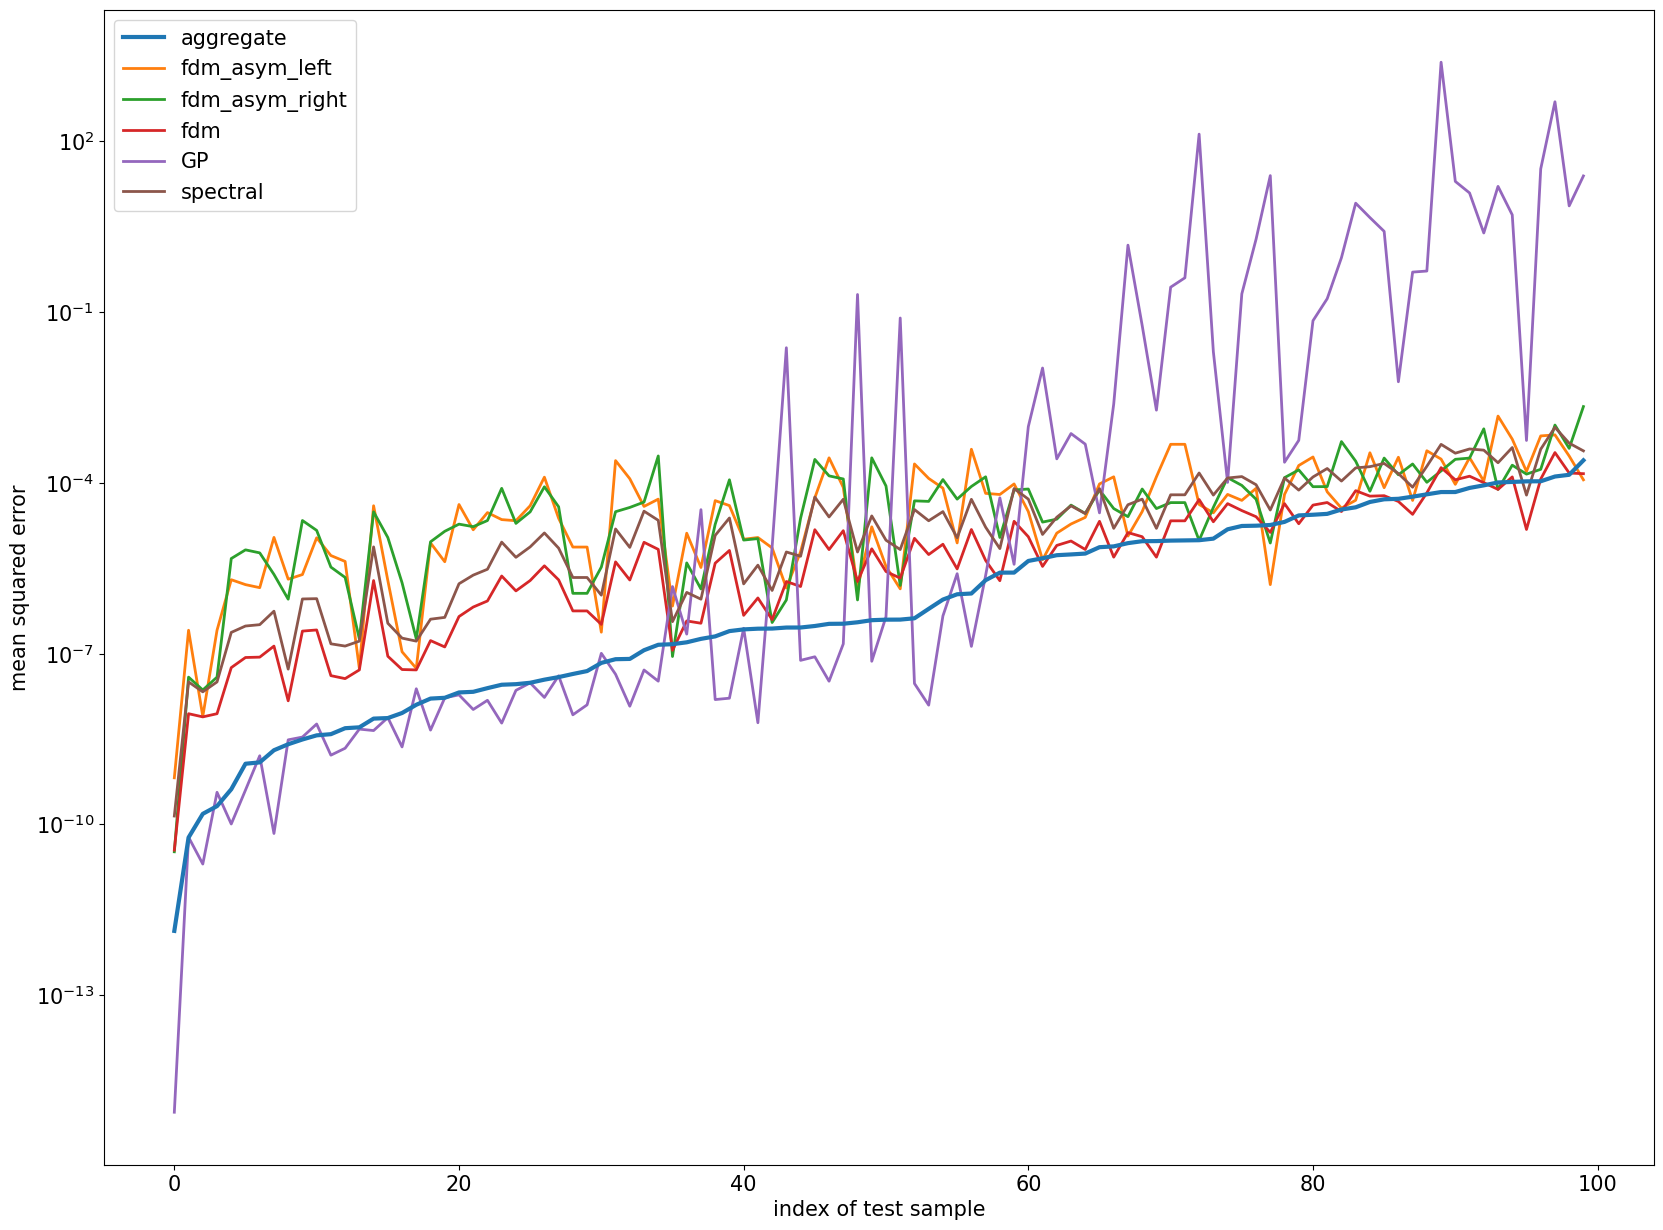

In [36]:
plt.figure(figsize=(20,15))
fsize=15
index=np.argsort(errors_test[:,0])
for model,error in zip(['aggregate']+names,errors_test.T):
    if model=='aggregate':
        plt.plot(error[index],label=model,zorder=10,linewidth=3)
    else:
        plt.plot(error[index],label=model,linewidth=2)
plt.xlabel('index of test sample',fontsize=fsize)
plt.ylabel('mean squared error',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.yscale('log')
plt.legend(fontsize=fsize)

In [31]:

{name:val for name,val in zip(['aggregate']+names,np.log10(errors_test).mean(axis=0))}

{'aggregate': -6.2823898335500425,
 'fdm_asym_left': -4.699063951499103,
 'fdm_asym_right': -4.685279505928902,
 'fdm': -5.523232658790127,
 'GP': -4.7394065773175695,
 'spectral': -4.988388828824064}

# Visualizing a few examples

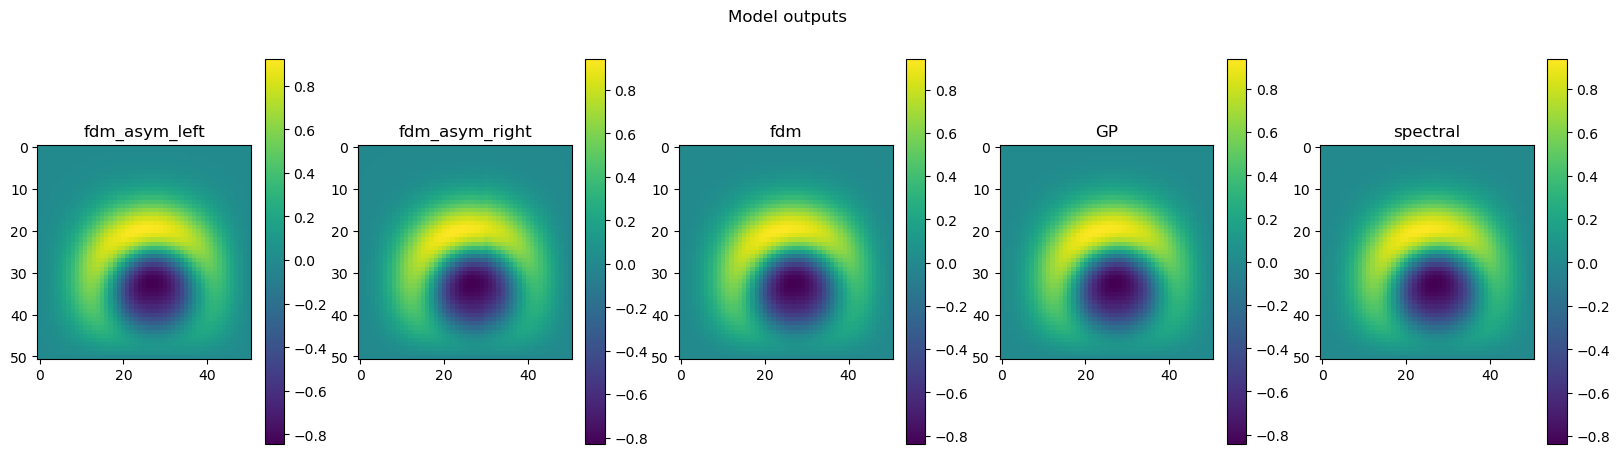

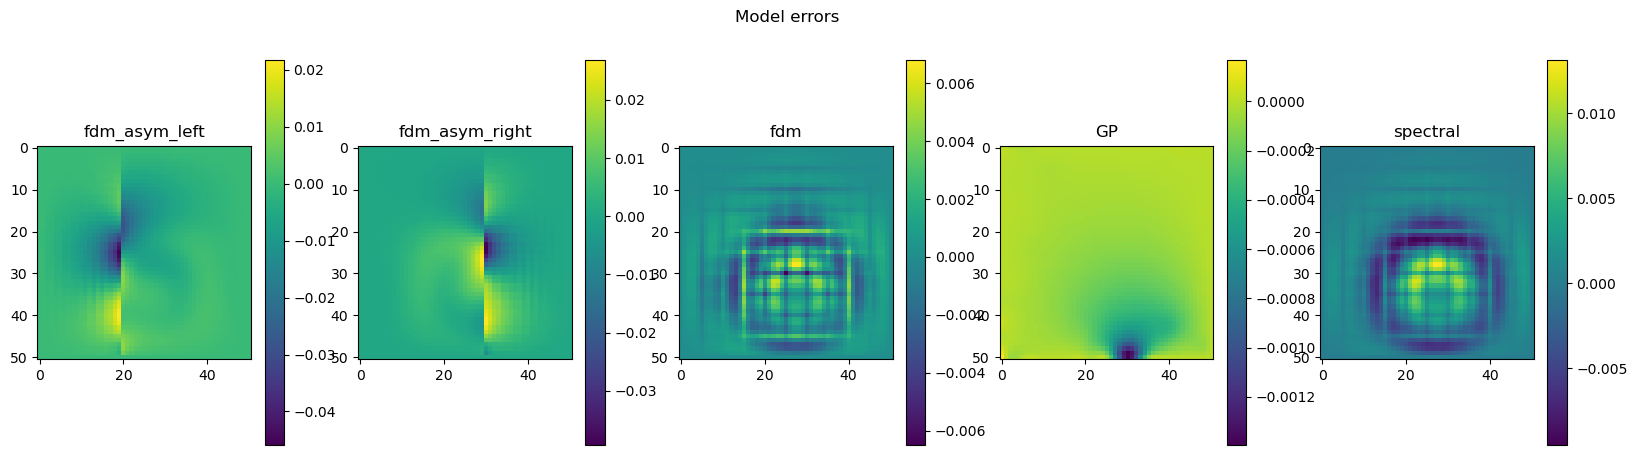

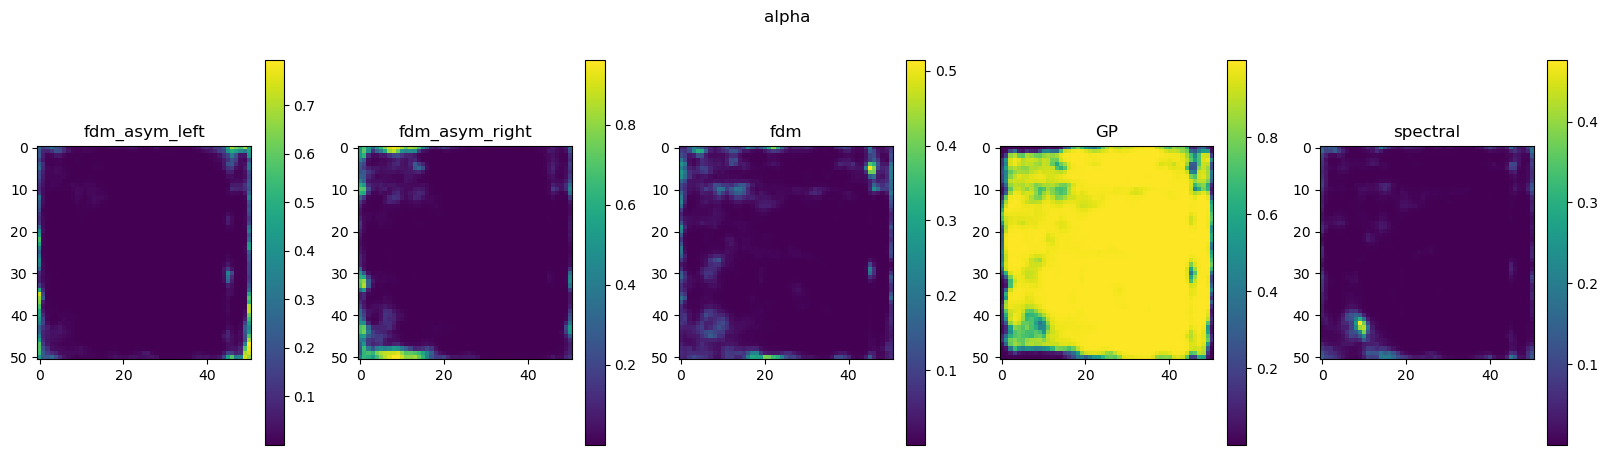

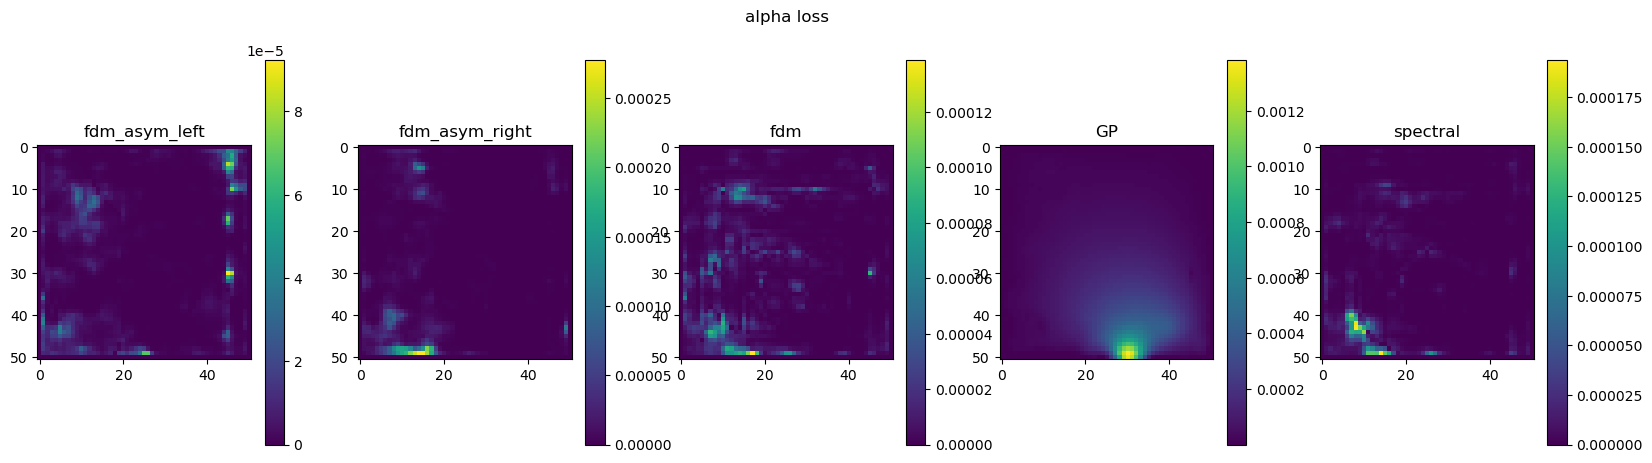

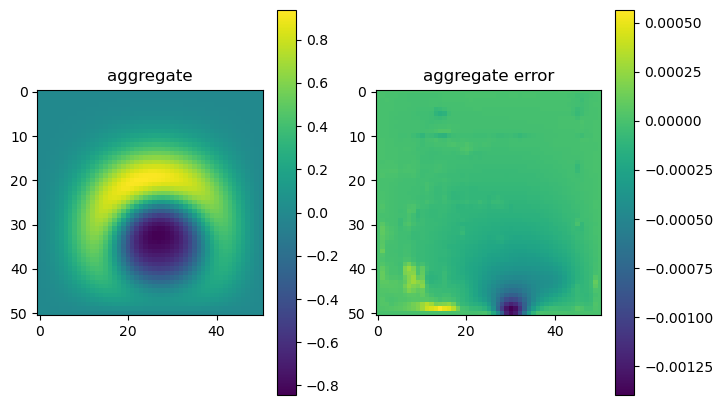

----------


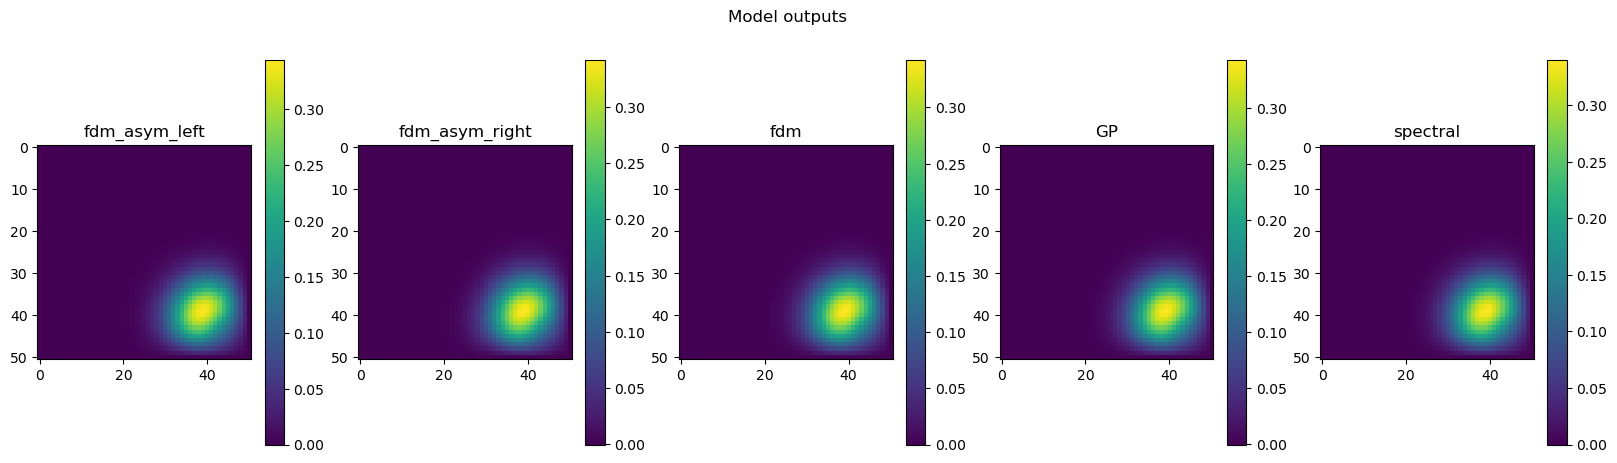

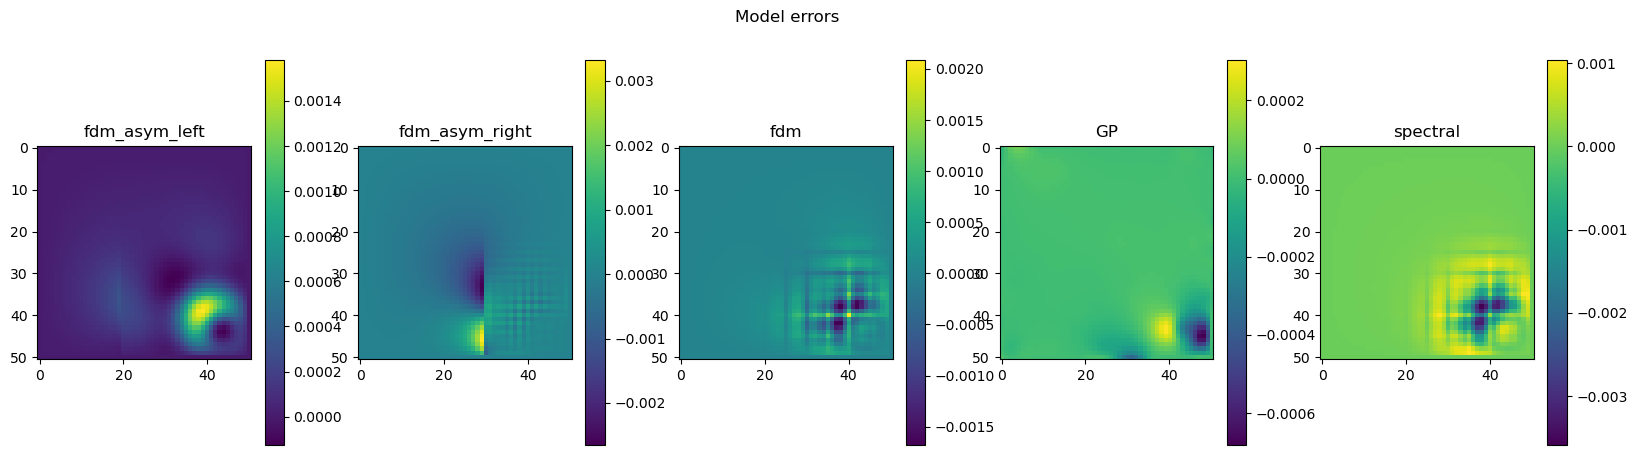

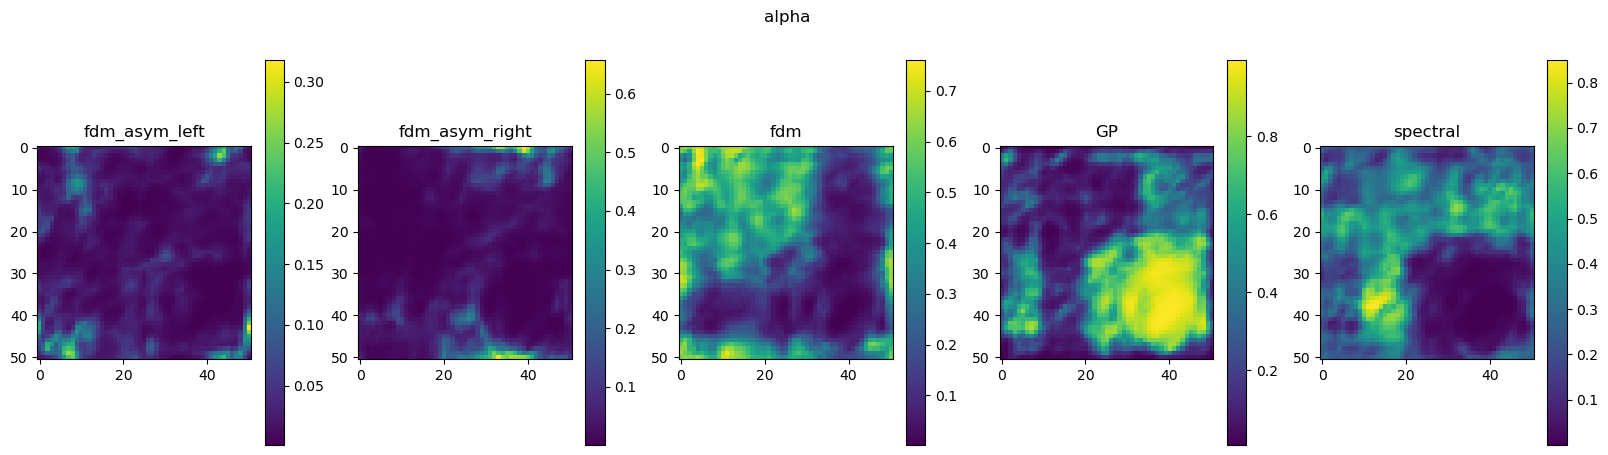

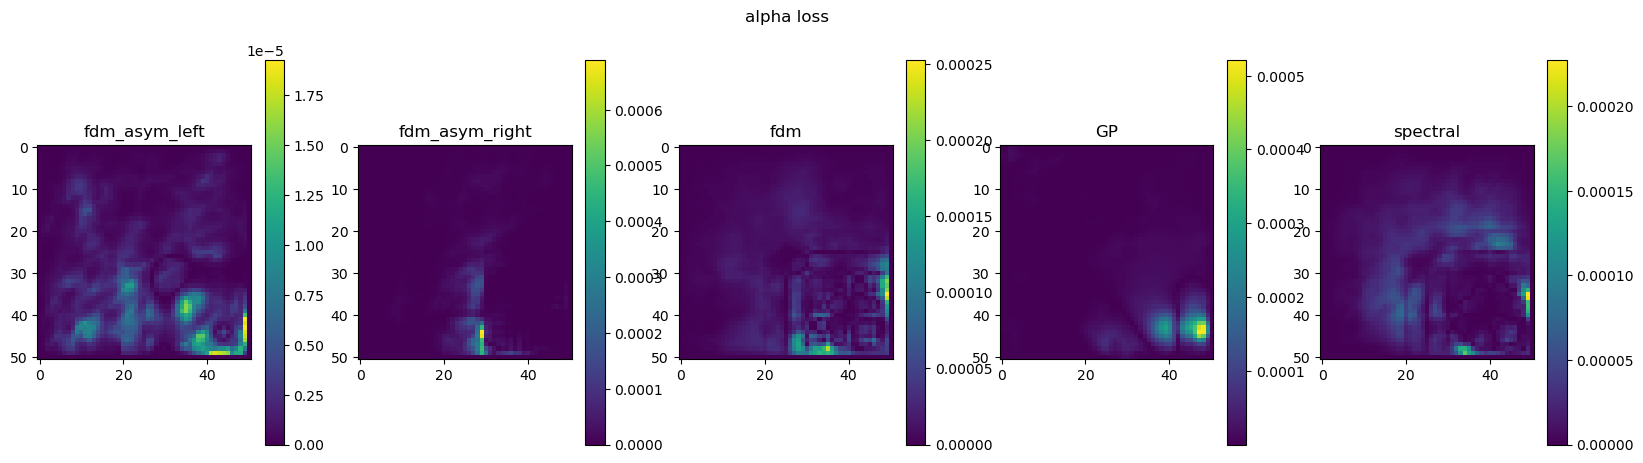

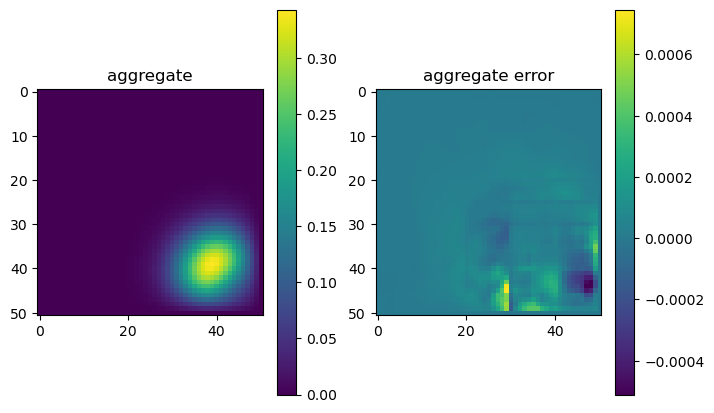

----------


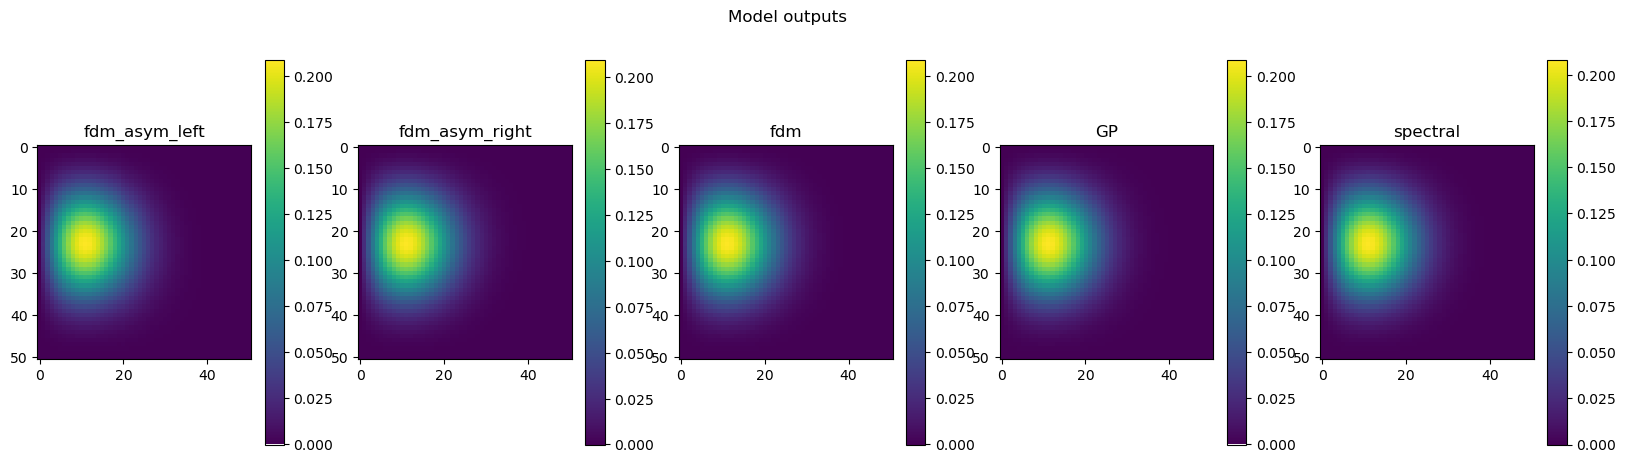

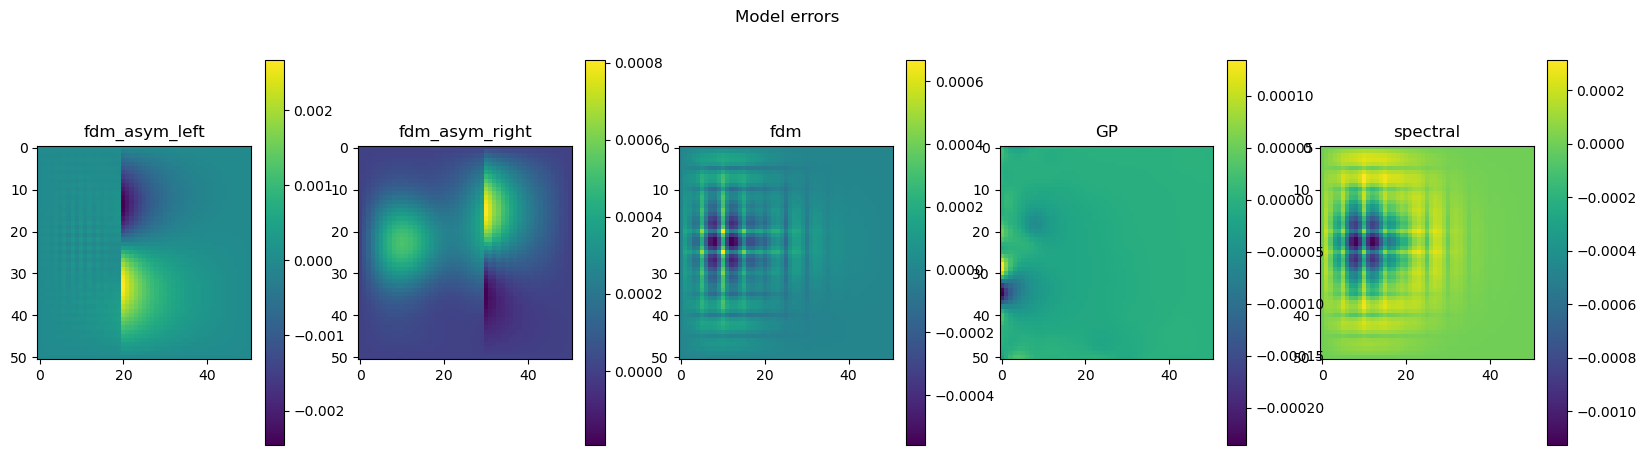

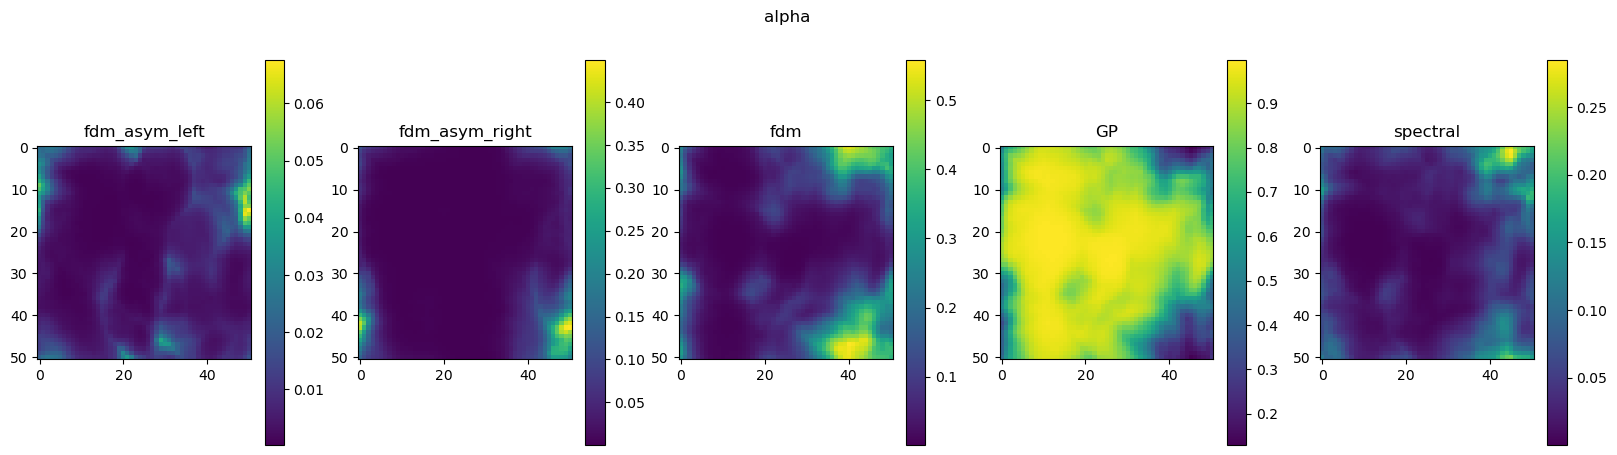

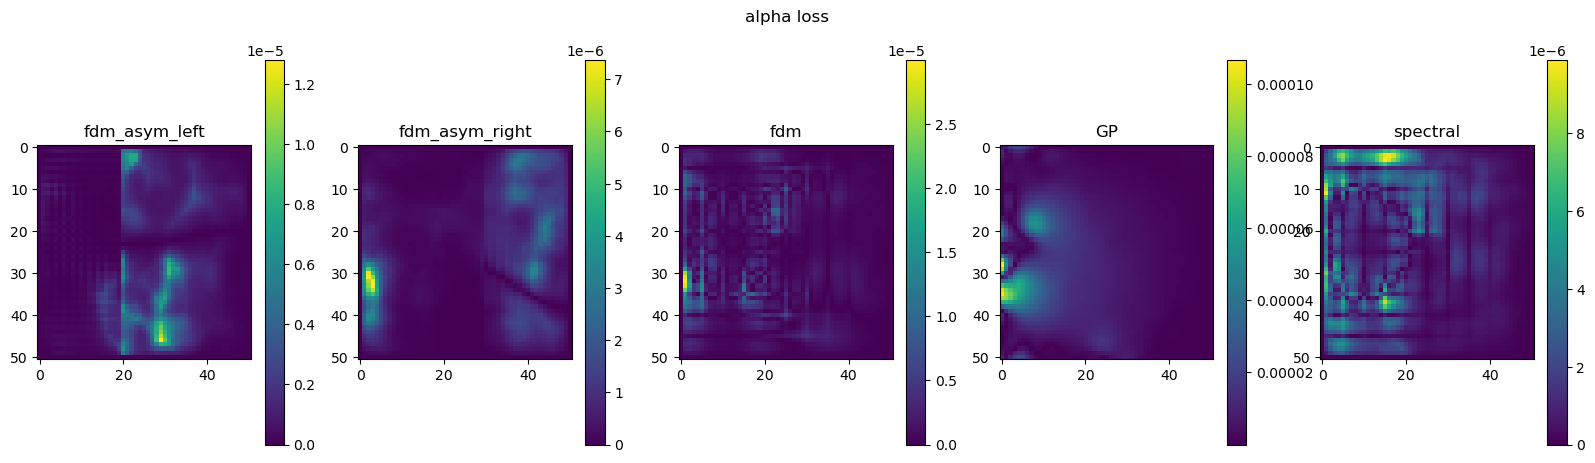

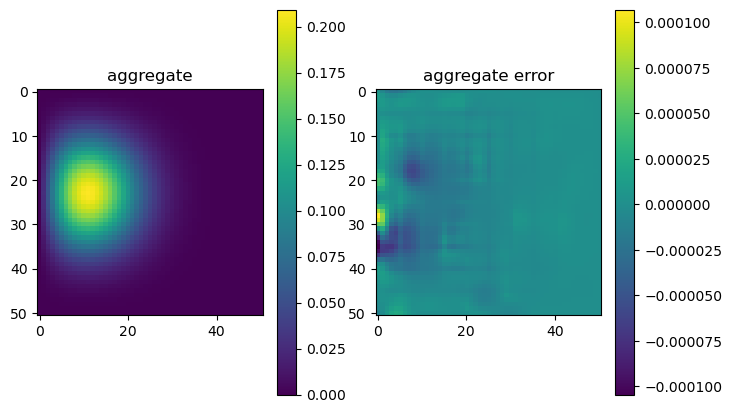

----------


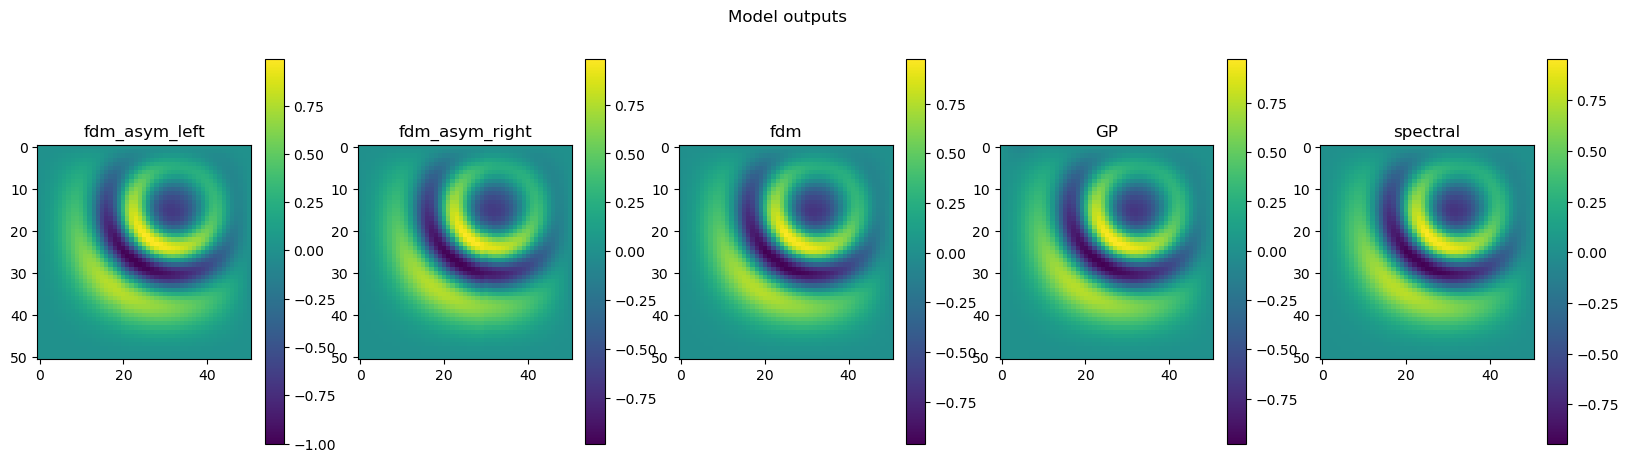

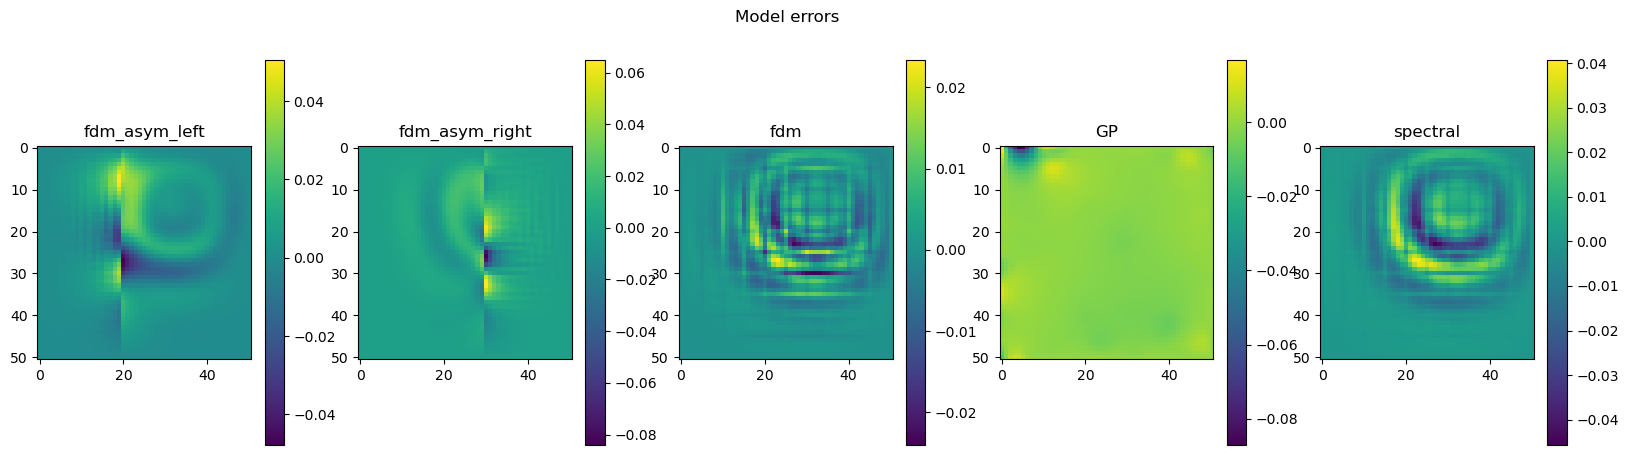

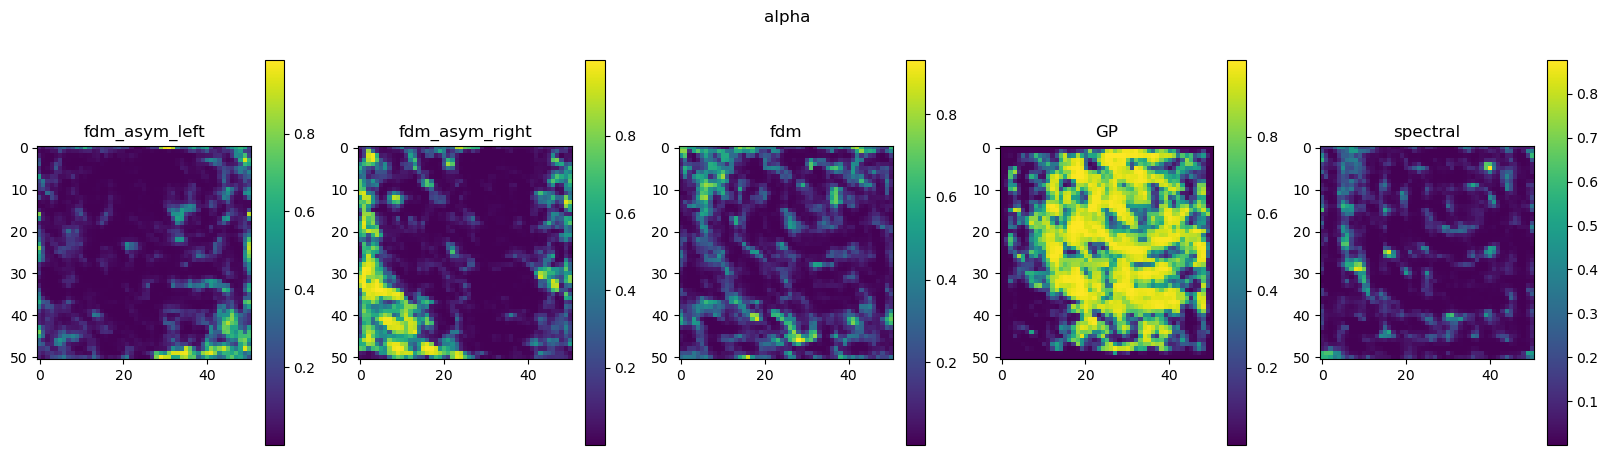

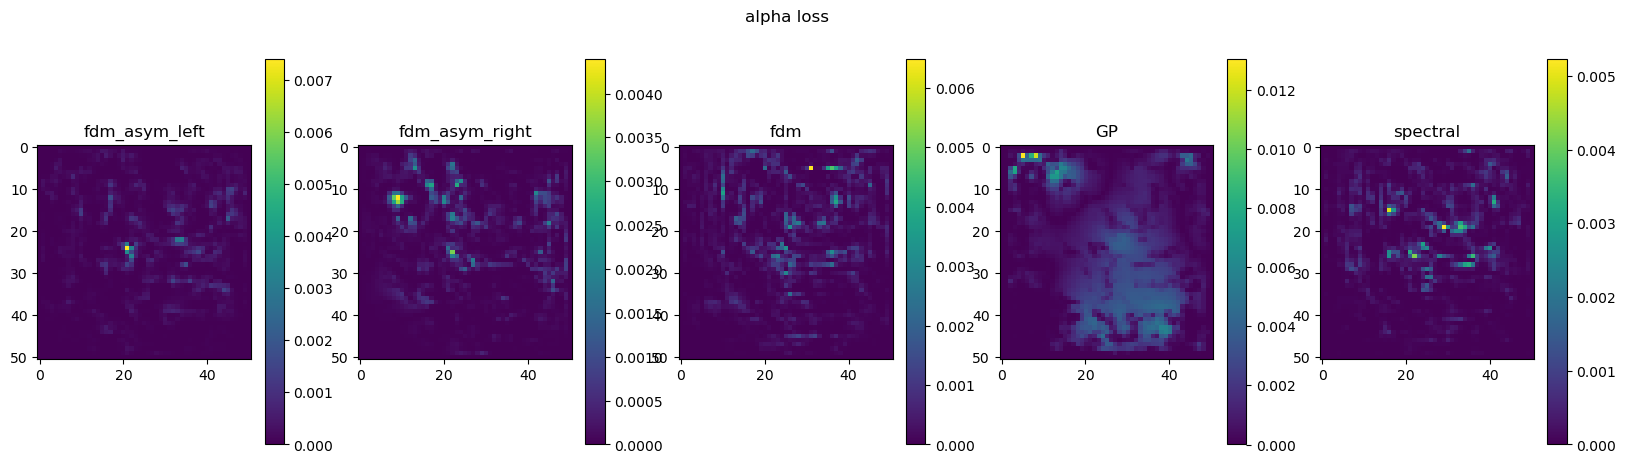

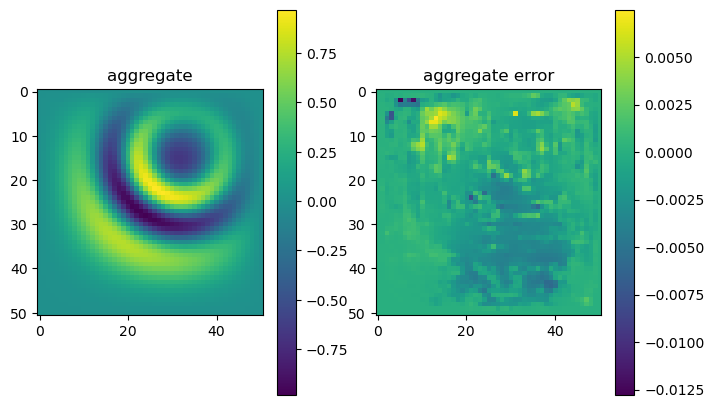

----------


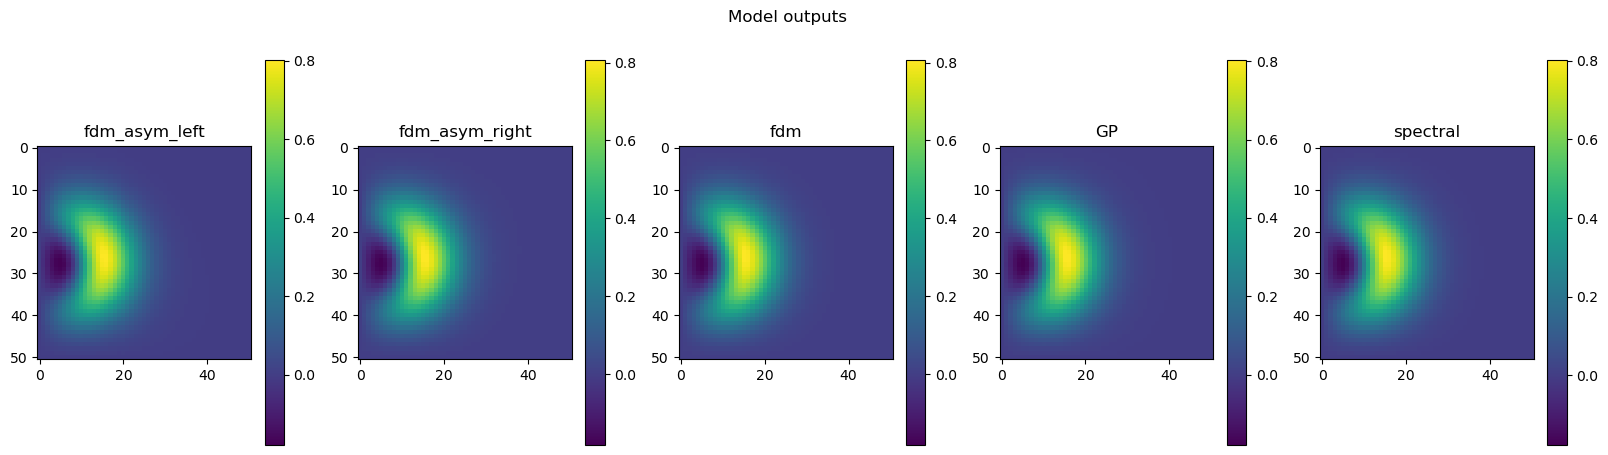

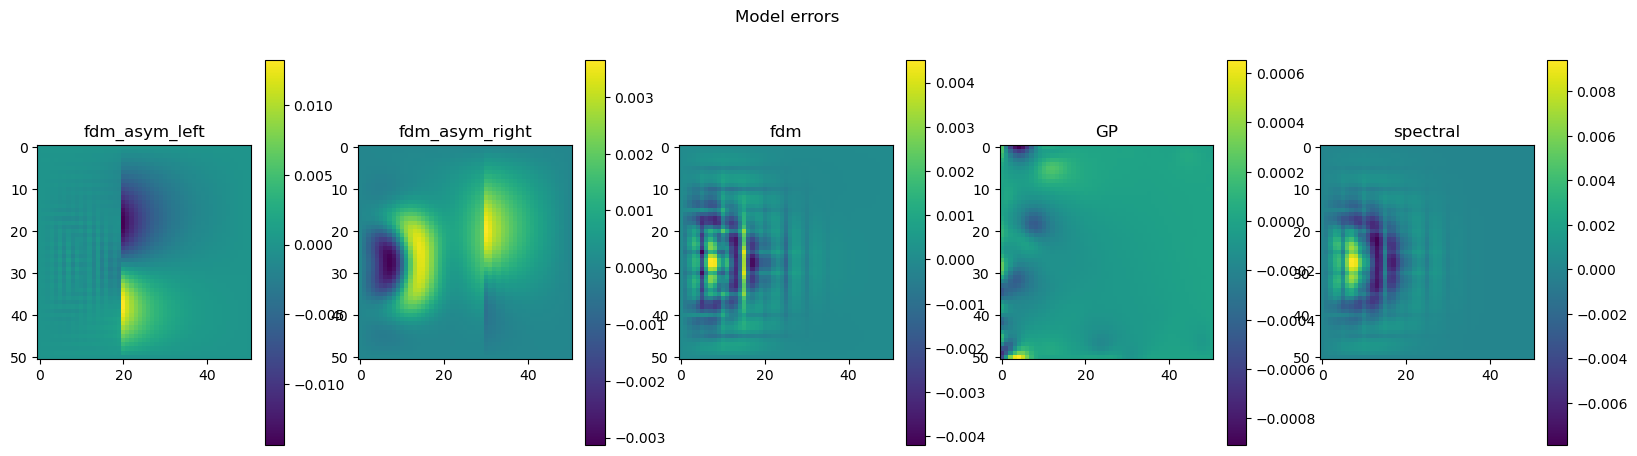

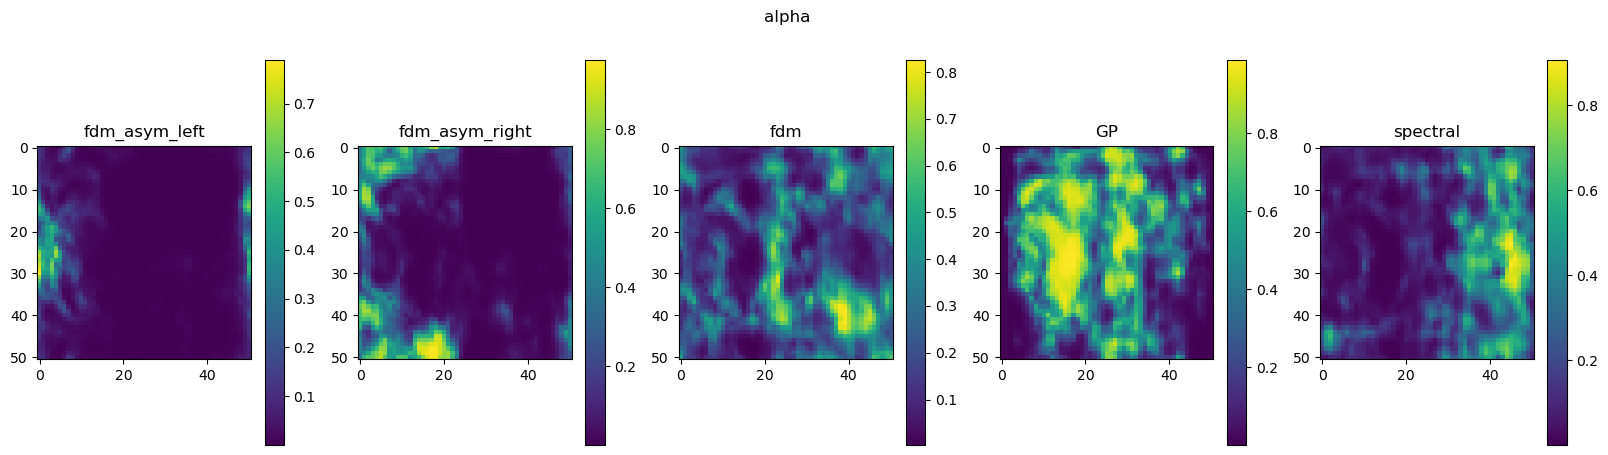

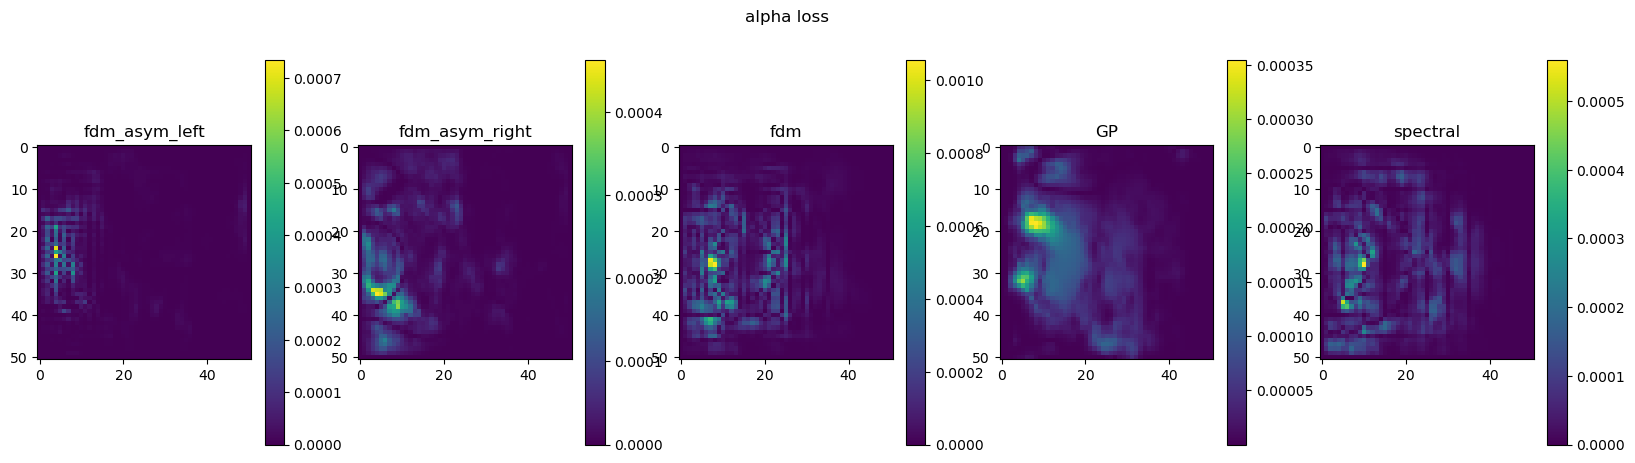

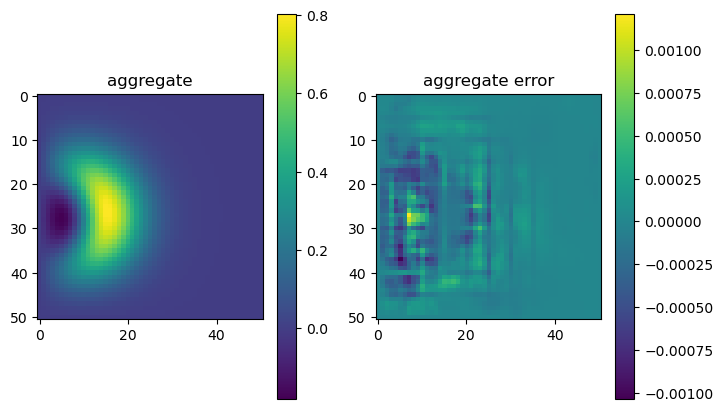

----------


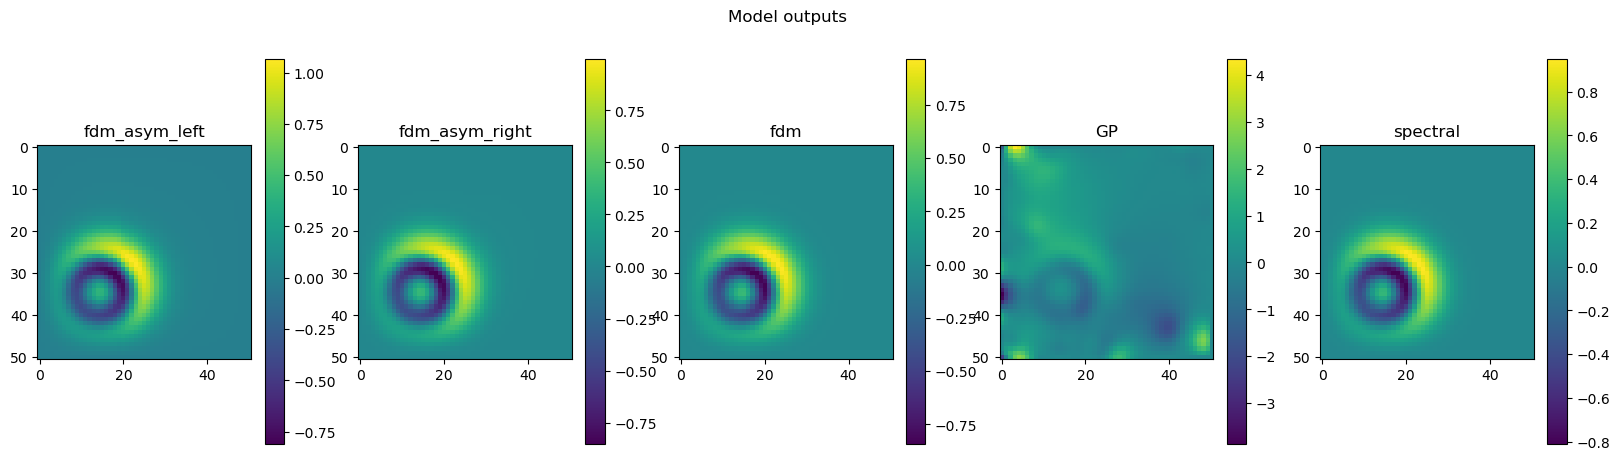

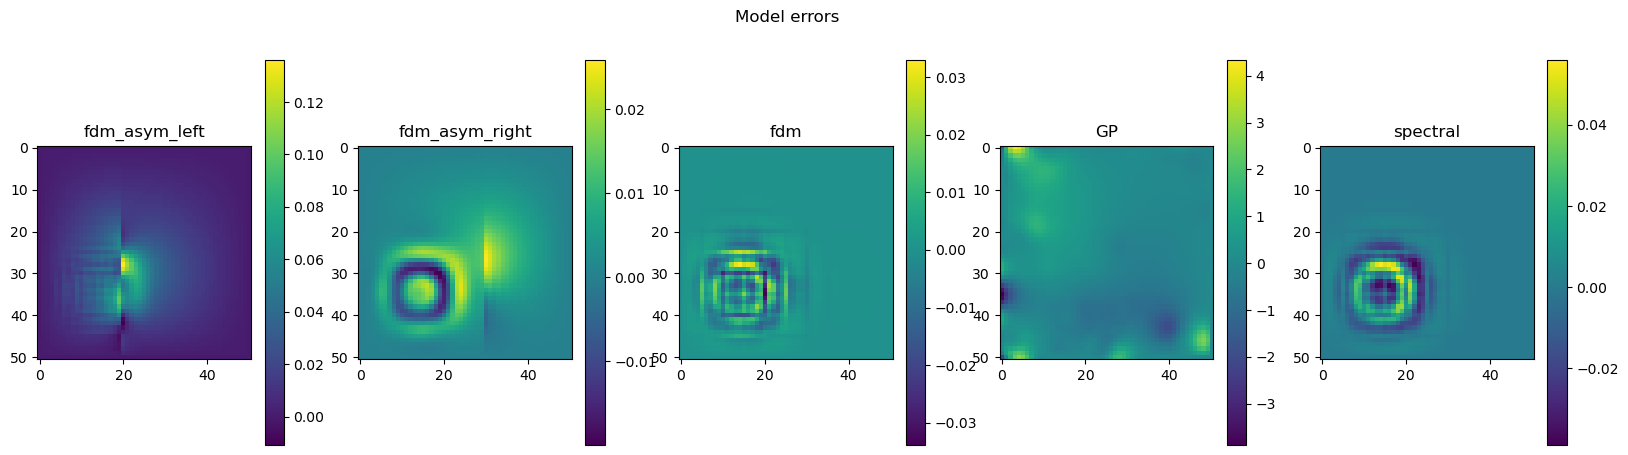

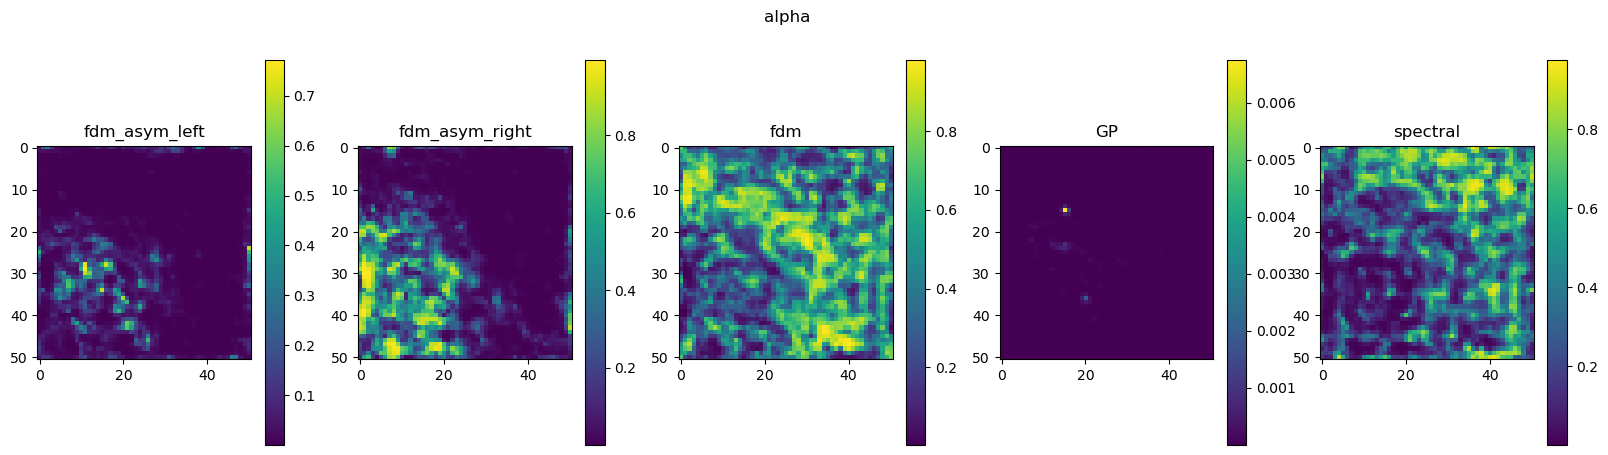

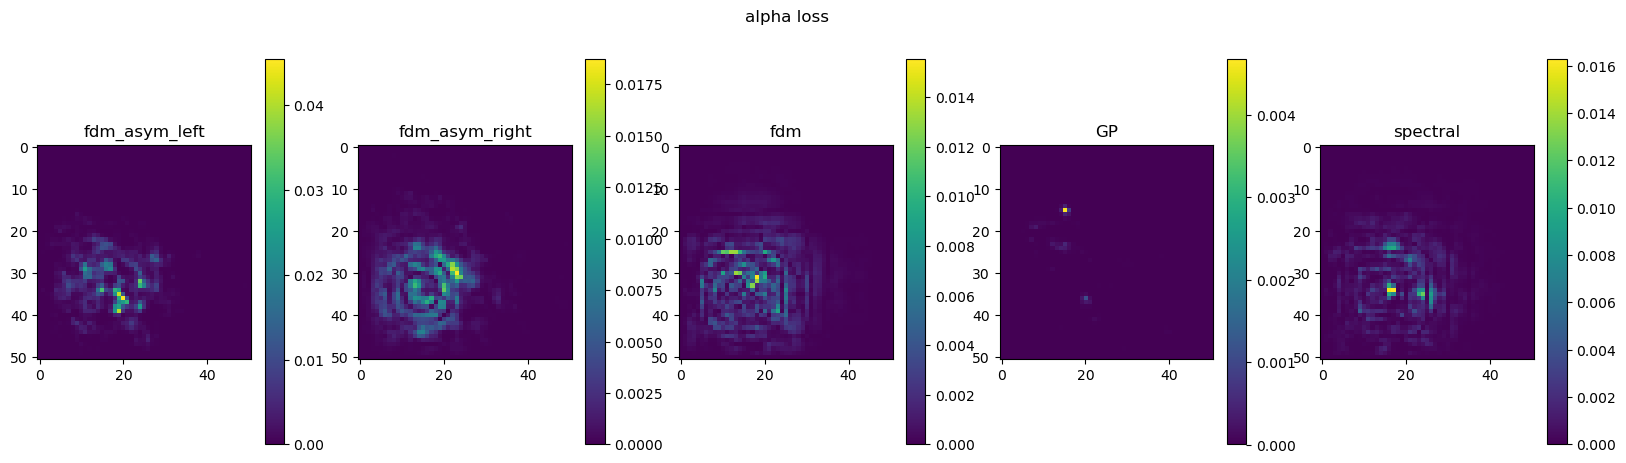

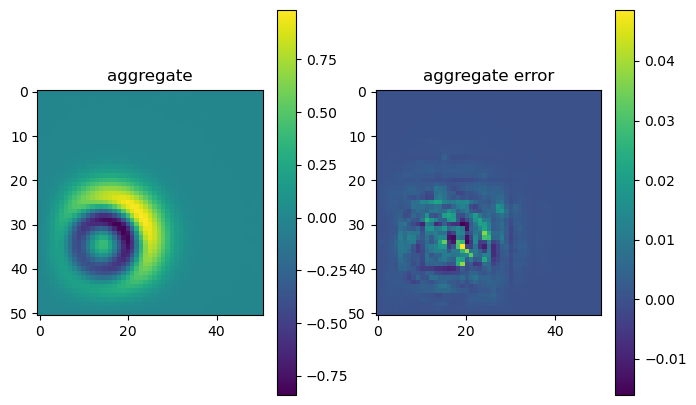

----------


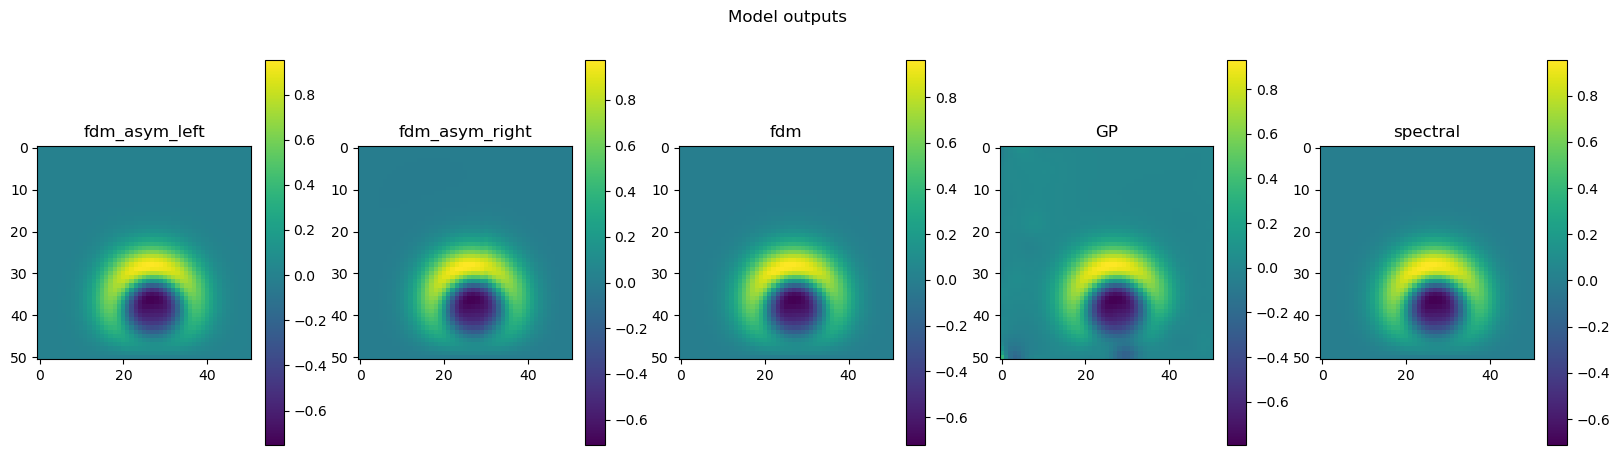

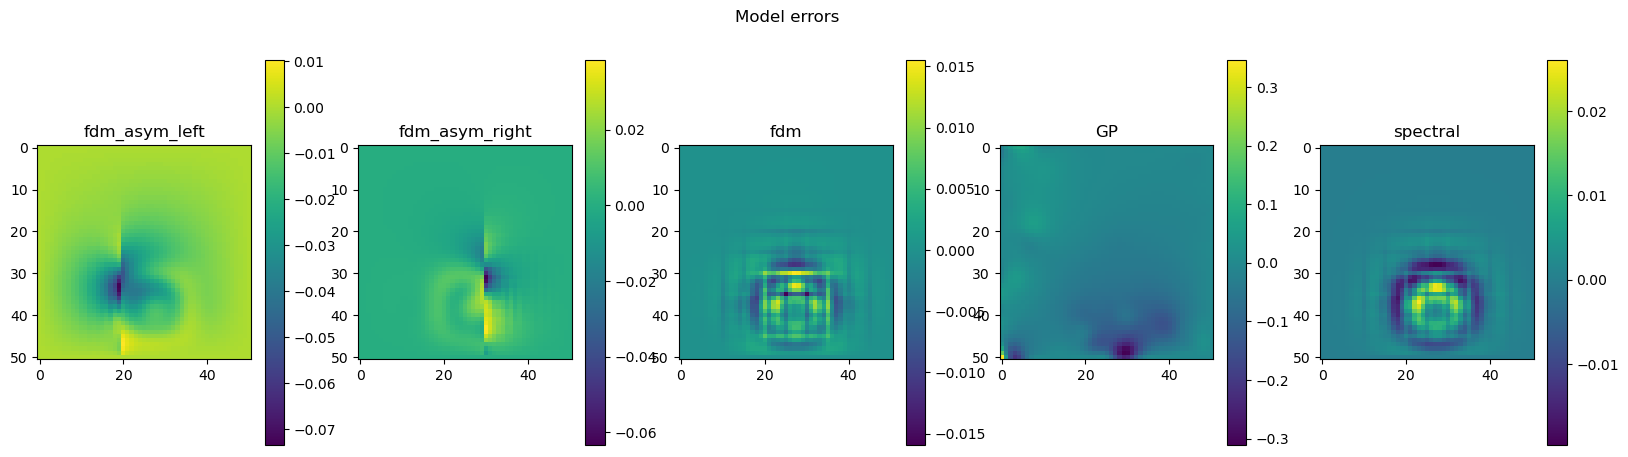

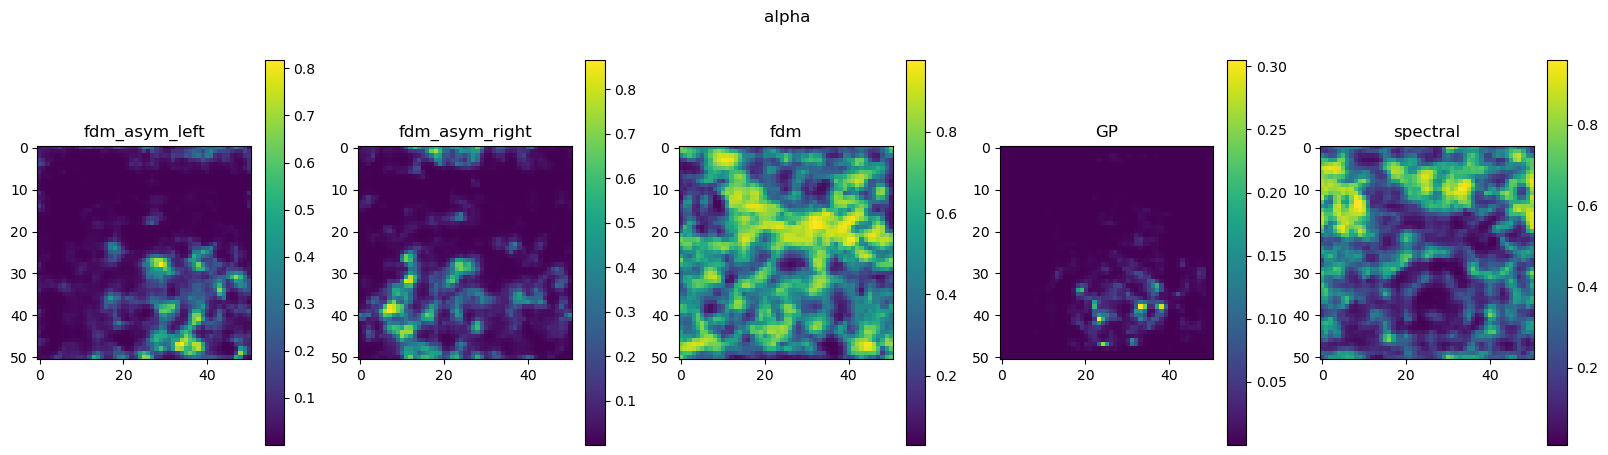

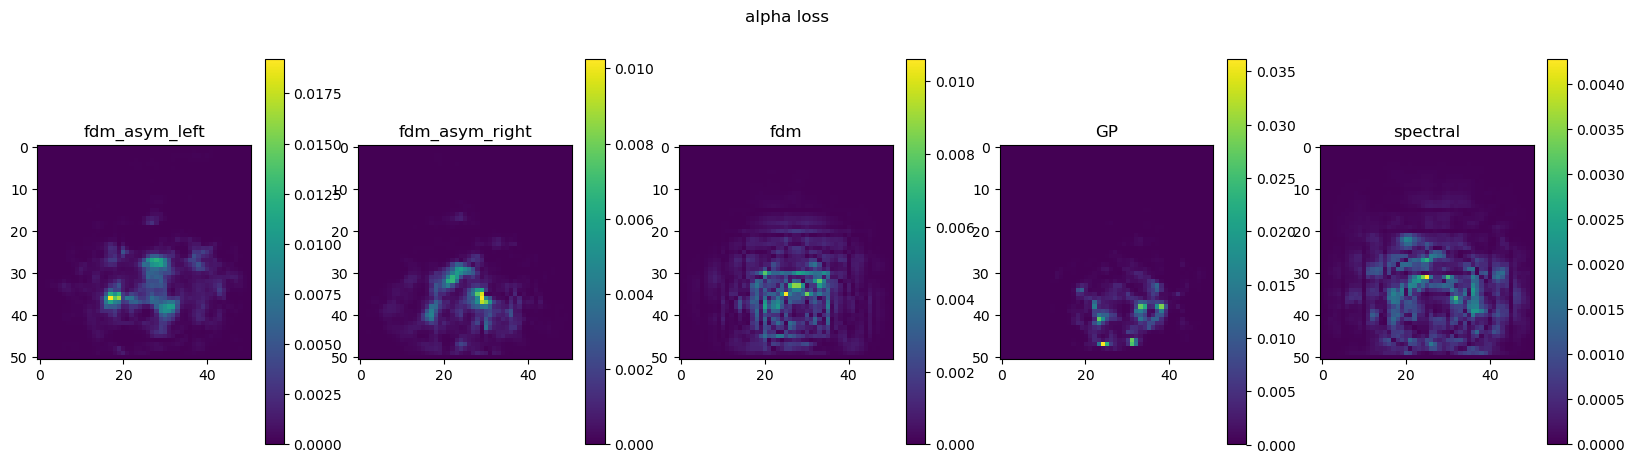

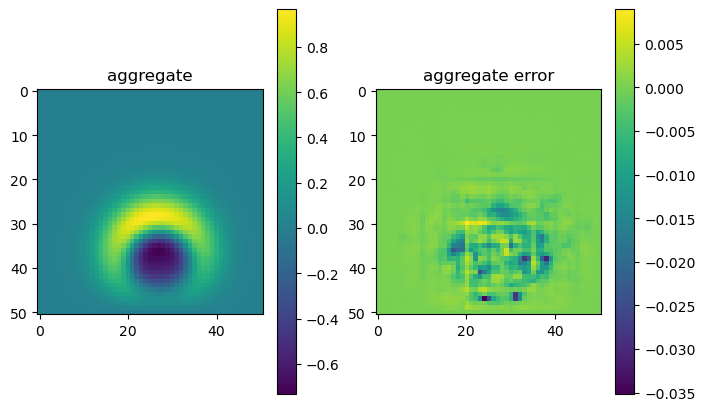

----------


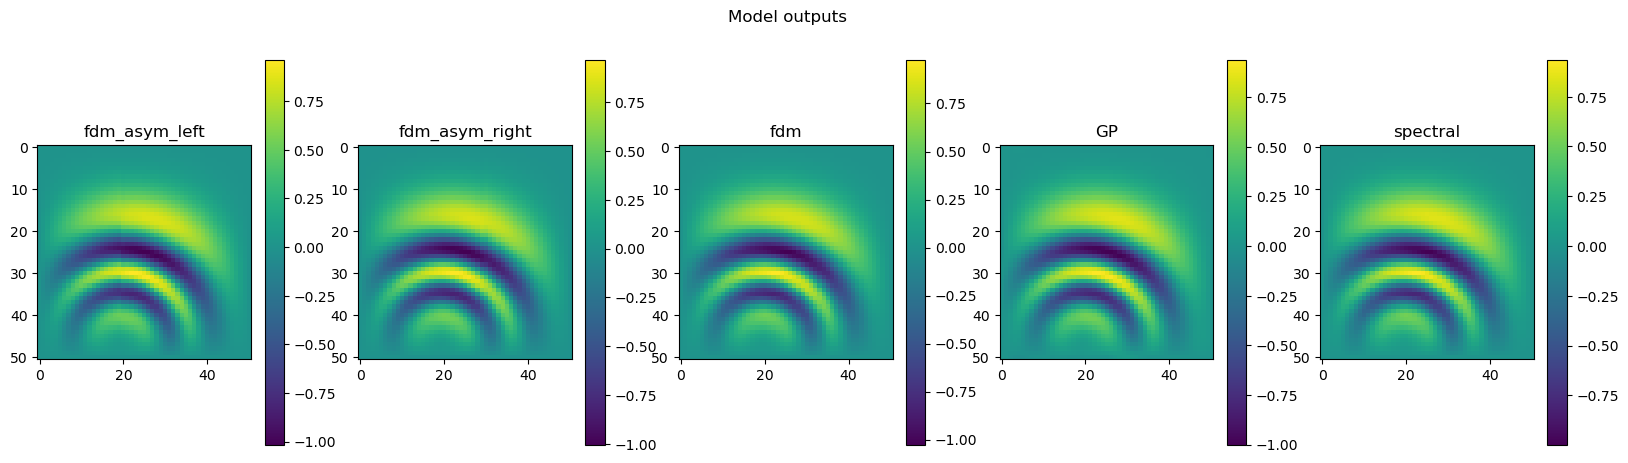

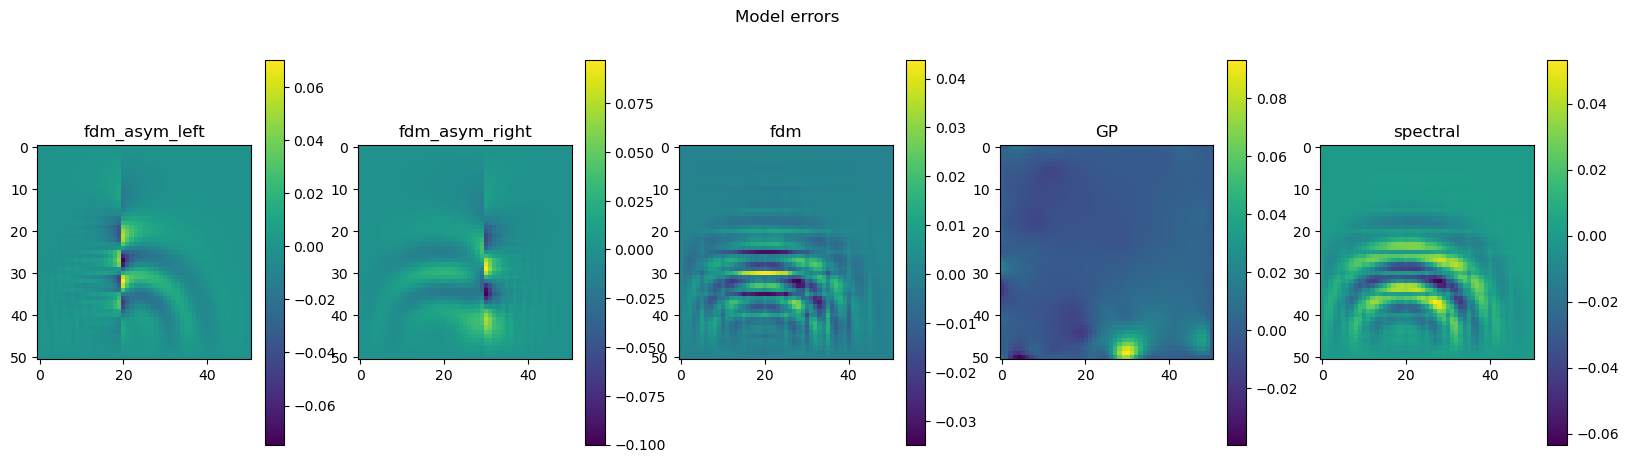

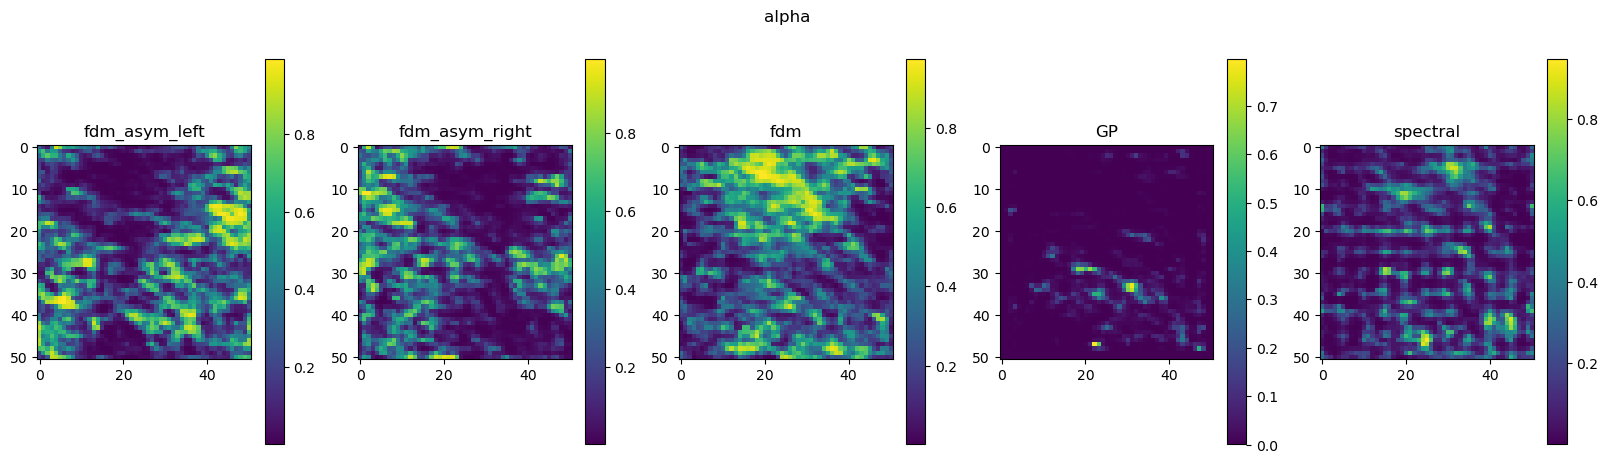

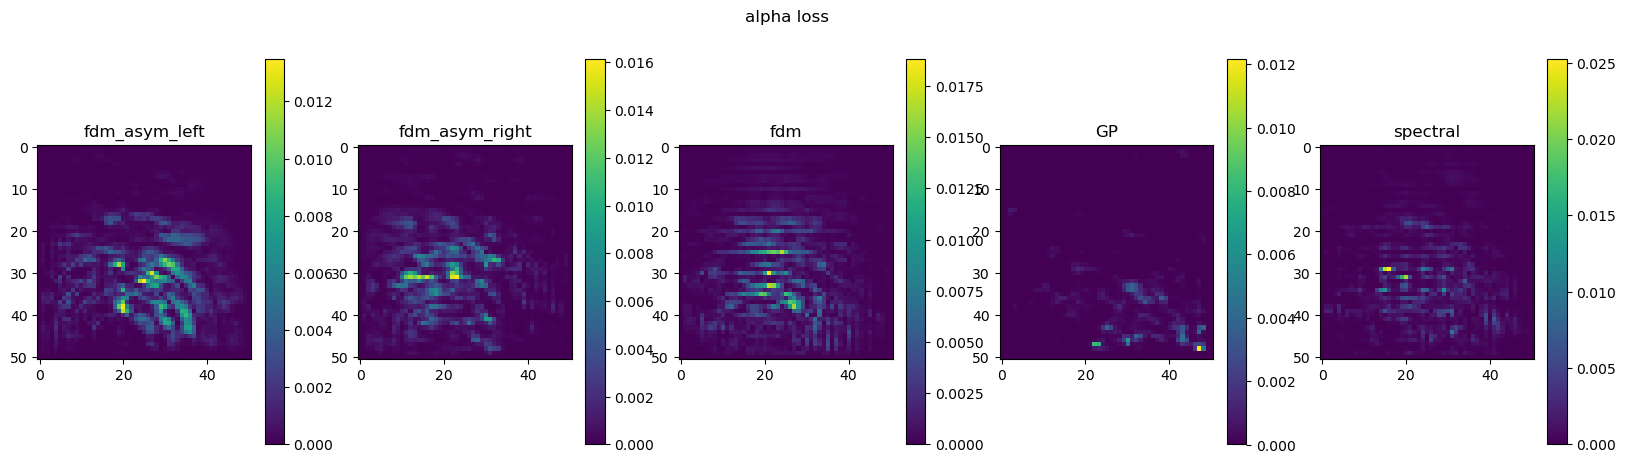

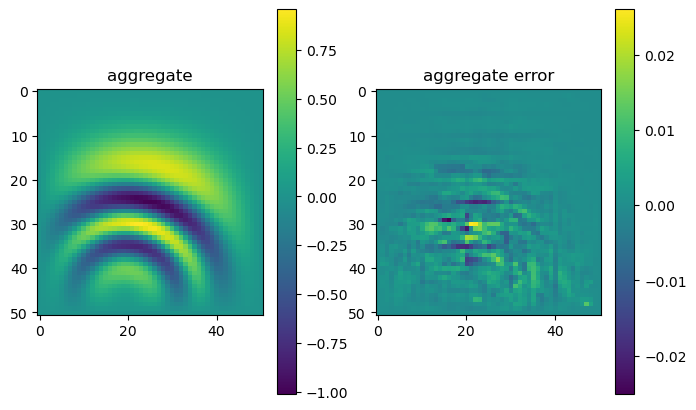

----------


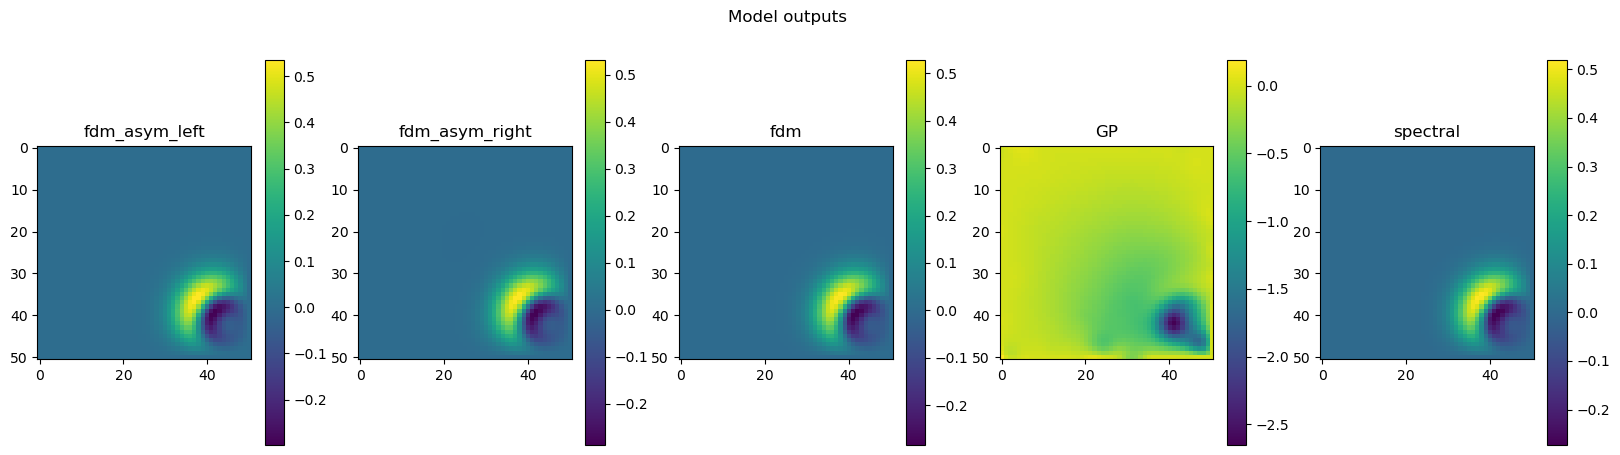

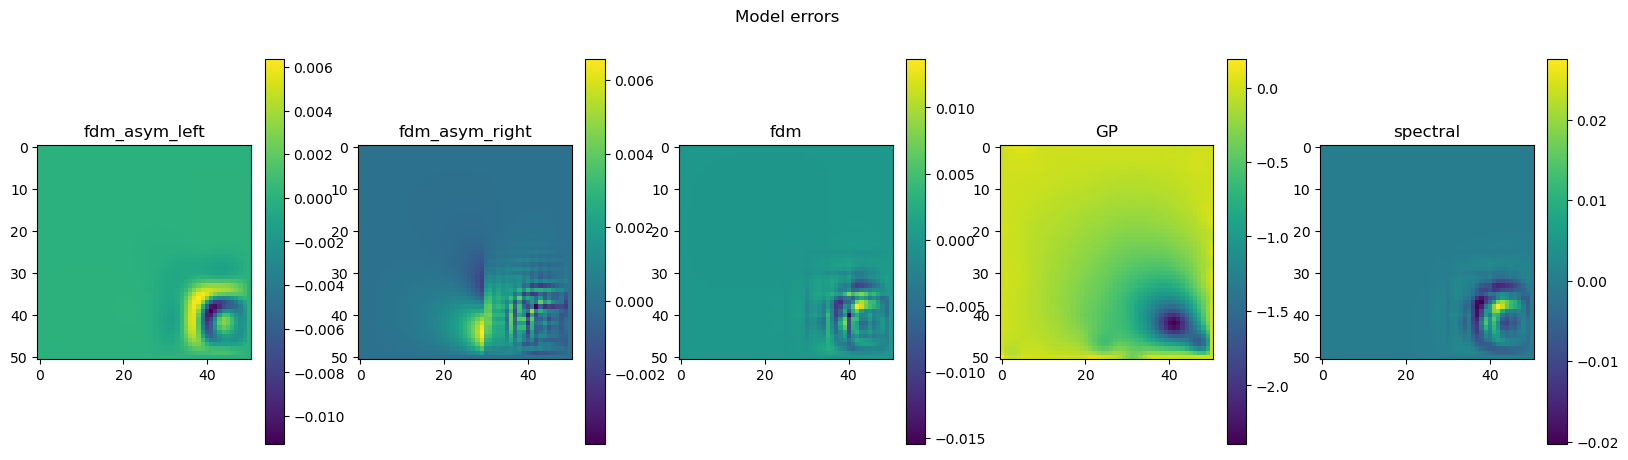

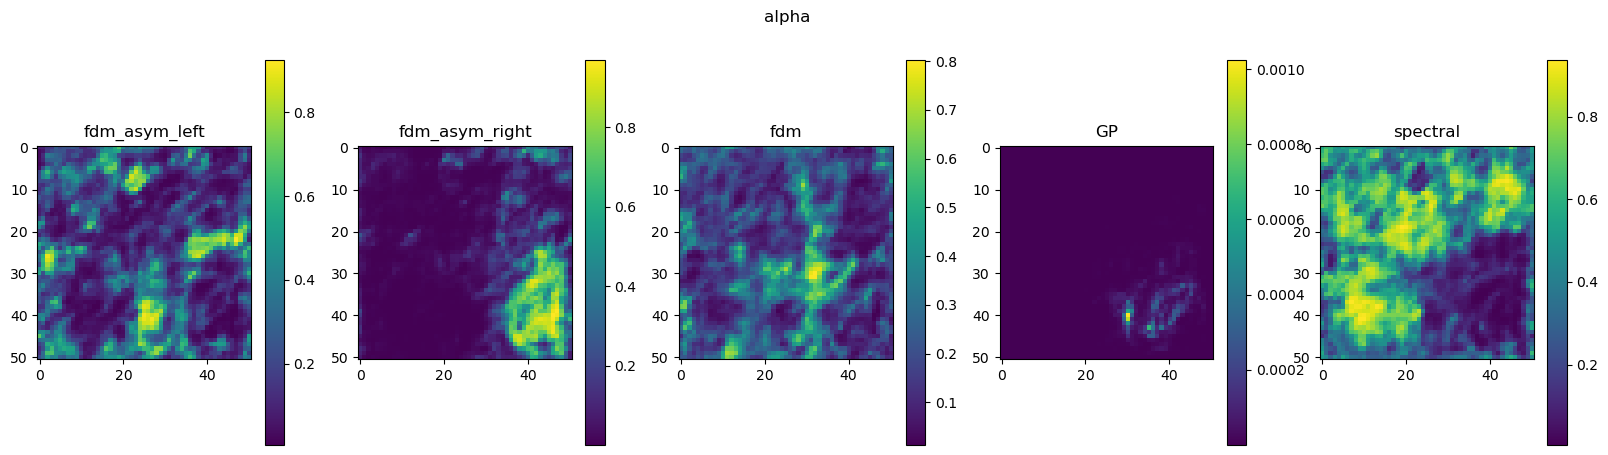

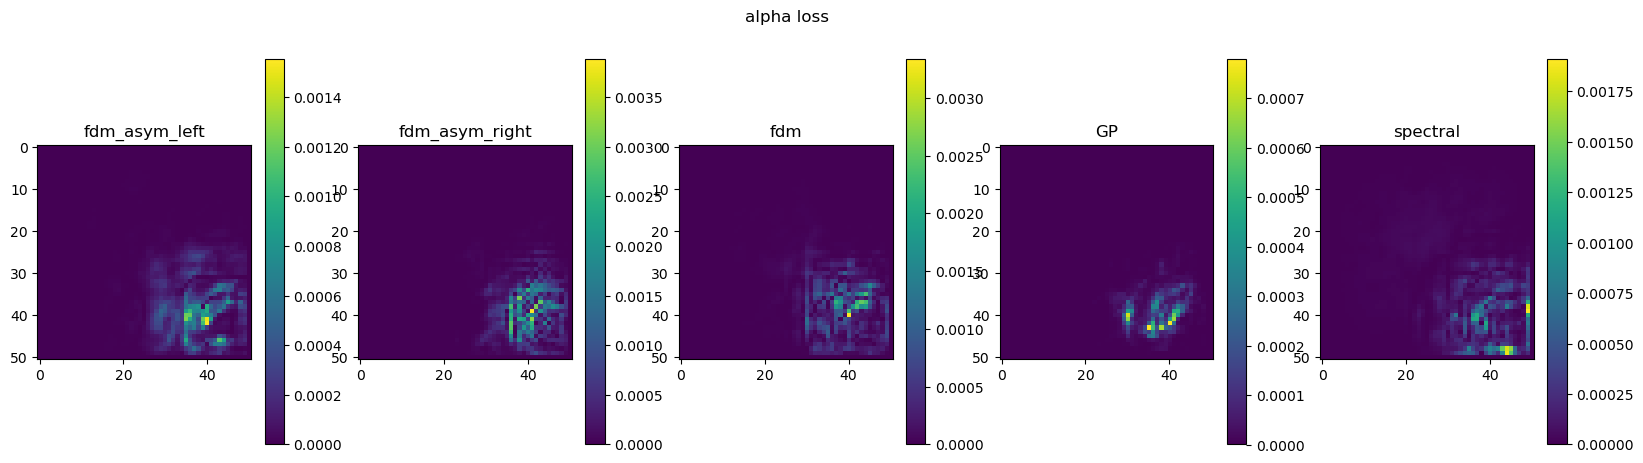

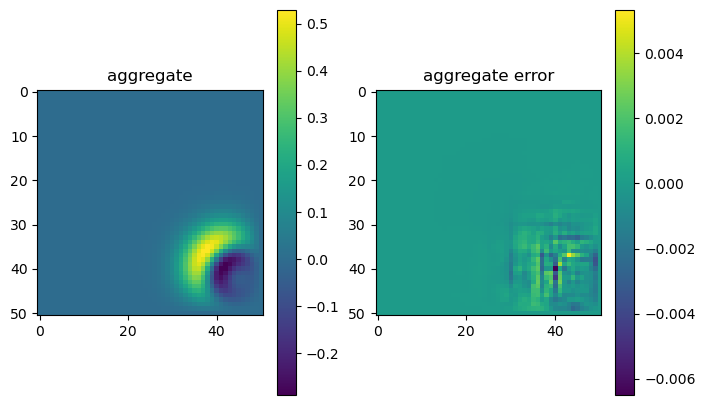

----------


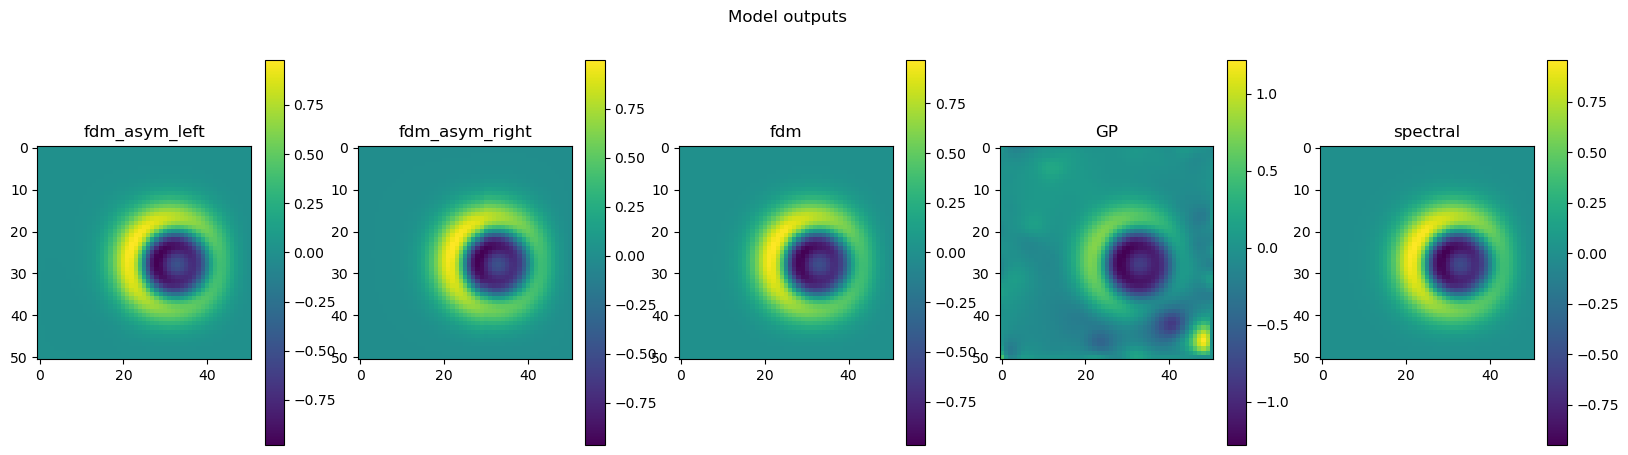

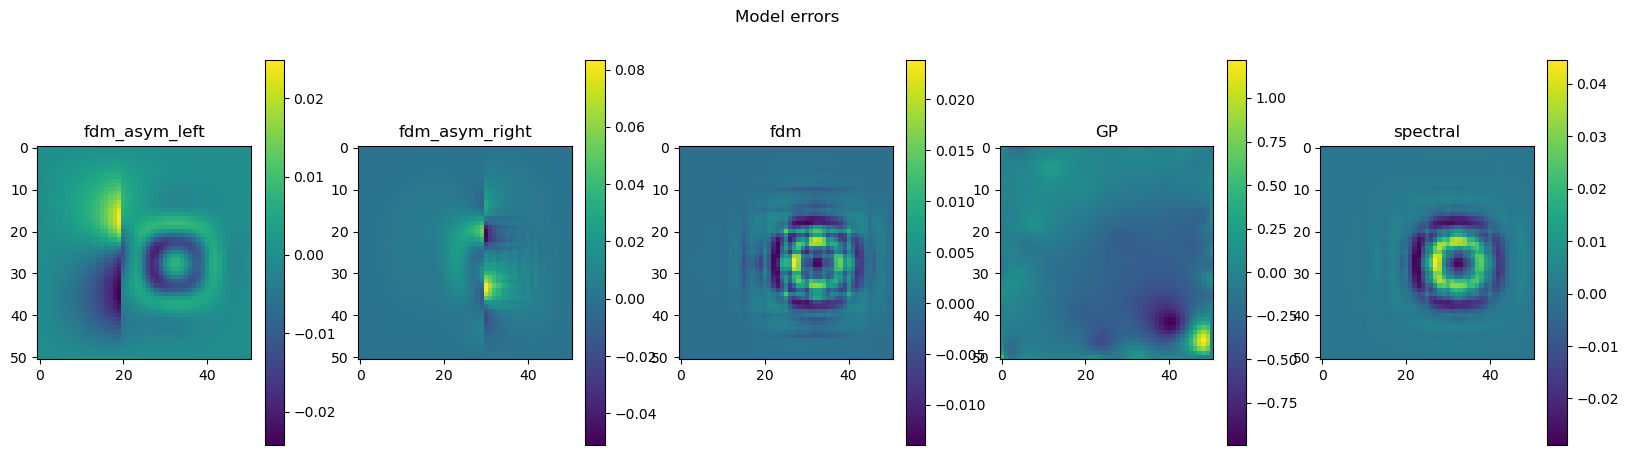

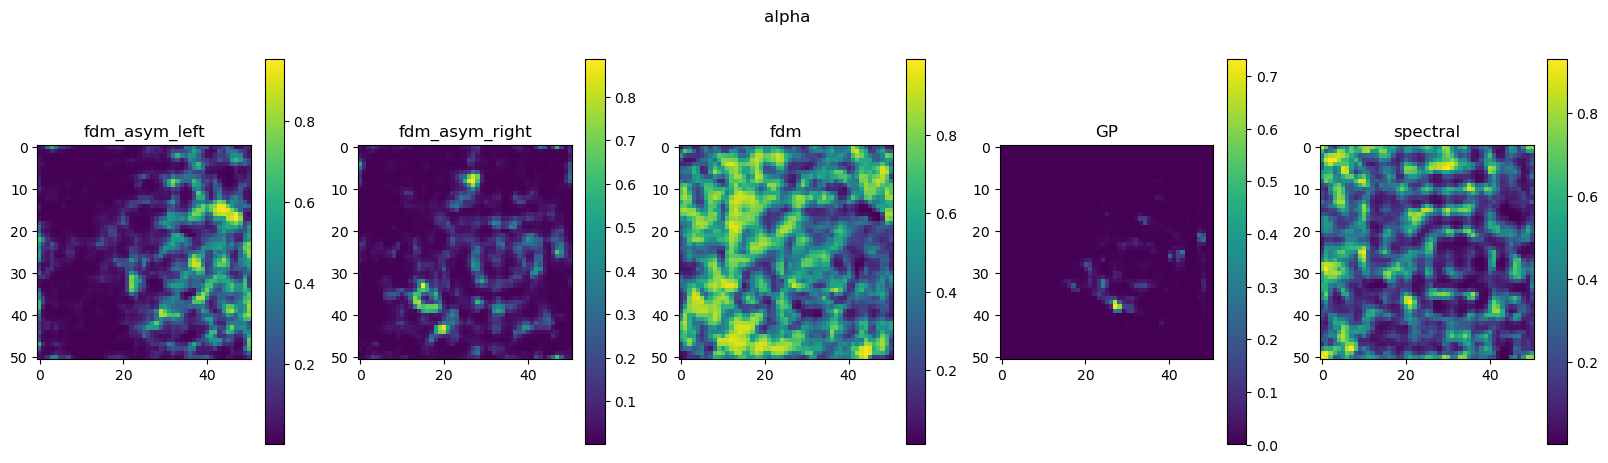

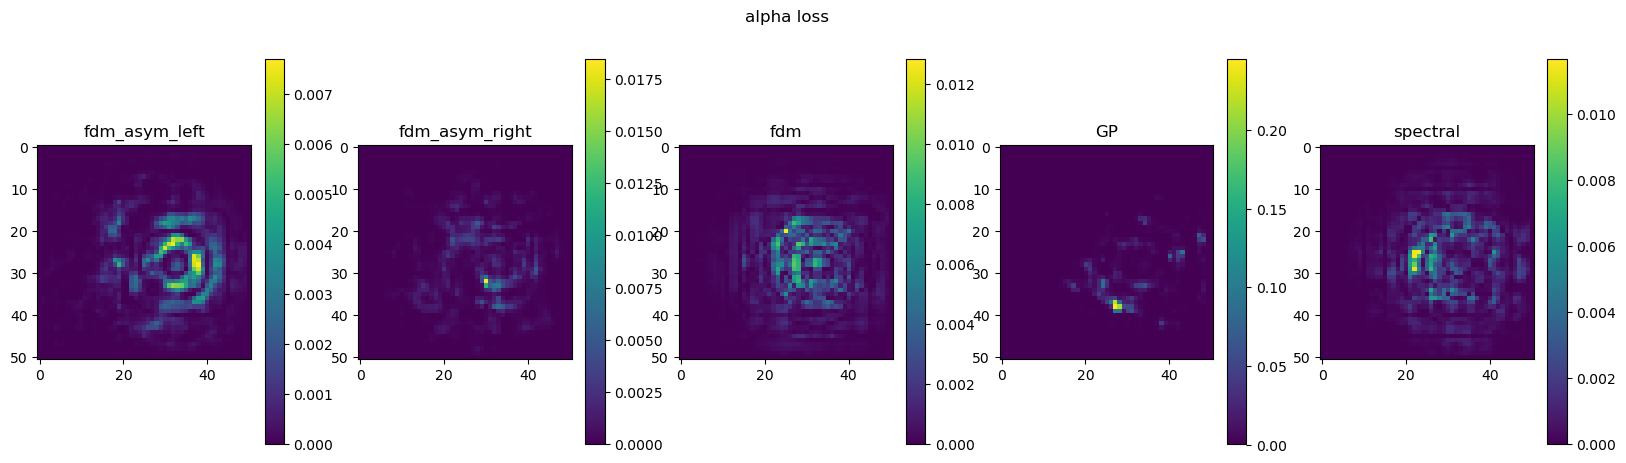

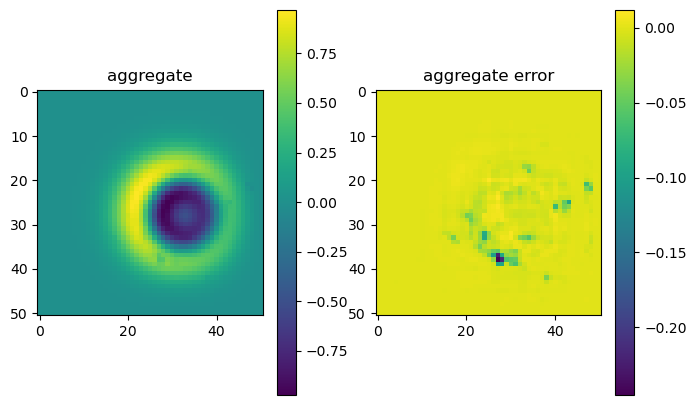

----------


In [32]:
for index in range(10):
    #make 5 subplots side by side
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(5):
        data=model_to_test[index,i].reshape(N_target+1,N_target+1)
        axs[i].imshow(data)
        axs[i].set_title(names[i])
        #colorbar
        fig.colorbar(axs[i].imshow(data), ax=axs[i])
    #suptitle
    fig.suptitle('Model outputs')
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(5):
        data=model_to_test[index,i].reshape(N_target+1,N_target+1)-Y_to_test[index]
        ax[i].imshow(data)
        ax[i].set_title(names[i])
        #colorbar
        fig.colorbar(ax[i].imshow(data), ax=ax[i])
    #suptitle
    fig.suptitle('Model errors')
    
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(5):
        data=alpha[index,i].reshape(N_target+1,N_target+1)
        ax[i].imshow(data)
        ax[i].set_title(names[i])
        #colorbar
        fig.colorbar(ax[i].imshow(data), ax=ax[i])
    #suptitle
    fig.suptitle('alpha')
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    for i in range(5):
        data=alpha[index,i].reshape(N_target+1,N_target+1)*np.abs(model_to_test[index,i].reshape(N_target+1,N_target+1)-Y_to_test[index])
        ax[i].imshow(data)
        ax[i].set_title(names[i])
        #colorbar
        fig.colorbar(ax[i].imshow(data), ax=ax[i])
    #suptitle
    fig.suptitle('alpha loss')
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    ax[0].imshow(pred[index].reshape(N_target+1,N_target+1))
    ax[0].set_title('aggregate')
    #colorbar
    fig.colorbar(ax[0].imshow(pred[index].reshape(N_target+1,N_target+1)), ax=ax[0])
    ax[1].imshow(pred[index].reshape(N_target+1,N_target+1)-Y_to_test[index])
    ax[1].set_title('aggregate error')
    #colorbar
    fig.colorbar(ax[1].imshow(pred[index].reshape(N_target+1,N_target+1)-Y_to_test[index]), ax=ax[1])
    
    plt.show()
    print('-'*10)